In [75]:
import os
import re
from pathlib import Path
import pickle
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence
from skopt.space import Integer, Real
from skopt.utils import use_named_args

from simulation_utils.calibration import compute_cosine_similarity_pd, _sample_pairs
from simulation_utils.datasets import DataStats, az_music_5core
from simulation_utils.preference import LatentDirichletAllocationCSR, IndianBuffetProcessCSR
from simulation_utils.observation import PopularityObservationCSR, UniformObservationCSR
from simulation_utils.observation import TruncParetoProfile
# %matplotlib inline

In [76]:
def ibp_unif_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='ibp_unif.pkl', savetofile=True, cap=True):
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper, cap)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [3]:
def ibp_pop_pareto(nusers=943, alpha=825.104806974929, c=0.8769365301765374, sigma=0,
                   m=20.00000045, obs_alpha=0.510528, upper=737,
                   fname='ibp_pop.pkl', savetofile=True, cap=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = IndianBuffetProcessCSR(nusers, alpha, c, sigma).generate()
    trunc_pareto = TruncParetoProfile(m, obs_alpha, upper, cap)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [4]:
def lda_pop_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                   m=20.00000045, alpha=0.510528, upper=737,
                   fname='lda_pop.pkl', savetofile=True, cap=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper, cap)
    obs = PopularityObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [5]:
def lda_unif_pareto(nusers=943, nitems=1682, k=10, lam=434.8731099953002, a=20.0, b=1.01, 
                    m=20.00000045, alpha=0.510528, upper=737,
                    fname='lda_unif.pkl', savetofile=True, cap=True):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = LatentDirichletAllocationCSR(nusers, nitems, k, lam, a, b).generate()
    trunc_pareto = TruncParetoProfile(m, alpha, upper, cap)
    obs = UniformObservationCSR(trunc_pareto).sample(pref)
    coo = obs.tocoo(copy=False)
    df = pd.DataFrame({'user': coo.row, 'item': coo.col, 'rating': coo.data})
    if savetofile:
        with open(f'data/simulated/{fname}', 'wb') as f:
            pickle.dump(df, f)
    return df

In [6]:
def compute_density(data):
    nusers = len(data['user'].unique())
    nitems = len(data['item'].unique())
    npairs = len(data)
    density = npairs / nitems / nusers
    return nusers, nitems, npairs, density

In [7]:
def compute_data_stats(data):
    pairs = data.loc[:, ['user', 'item']]
    user_activity = pairs.groupby('user', as_index=False).count().rename(columns={'item': 'count'})
    item_popularity = pairs.groupby('item', as_index=False).count().rename(columns={'user': 'count'})
    return user_activity, item_popularity

In [8]:
def summarize_dataset(name, data_func, *args, **kwargs):
    if isinstance(data_func, pd.DataFrame):
        dataset = data_func
    else:
        dataset = data_func(*args, **kwargs)
    colname = dataset.columns
    if not {'user', 'item'}.issubset(colname):
        dataset.rename(columns={colname[0]: 'user',
                                colname[1]: 'item'},
                       inplace=True)
    dataset = dataset[['user', 'item']]
    data_meta = compute_density(dataset)
    data_meta_stats = tuple([name, *data_meta])
    
    user_activity, item_popularity = compute_data_stats(dataset)
    user_activity['dataset'] = name
#     user_activity.drop('user', axis=1, inplace=True)
    item_popularity['dataset'] = name
#     item_popularity.drop('item', axis=1, inplace=True)
    item_popularity['rank'] = item_popularity['count'].rank(method='min', ascending=False)

    user_activity_stats = user_activity['count'].rename(name).describe()
    item_popularity_stats = item_popularity['count'].rename(name).describe()
    return data_meta_stats, user_activity_stats, item_popularity_stats, user_activity, item_popularity

In [9]:
def make_grids(figsize=(14, 6), ngrids_left=3, ngrids_right=1):
    fig = plt.figure(figsize=figsize)
    gs_left = GridSpec(ngrids_left, 1)
    gs_left.update(left=0.05, right=0.48, wspace=0.05, hspace=0.05)
    for i in range(ngrids_left):
        ax = plt.subplot(gs_left[i, 0])
    for ax in fig.axes[:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[1:]:
        ax.spines['top'].set_visible(False)

    gs_right = GridSpec(ngrids_right, 1)
    gs_right.update(left=0.55, right=0.98, wspace=0.05, hspace=0.05)
    for i in range(ngrids_right):
        ax = plt.subplot(gs_right[i, 0])
    for ax in fig.axes[ngrids_left:-1]:
        ax.spines['bottom'].set_visible(False)
        ax.tick_params(labelbottom=False, bottom=False)
    for ax in fig.axes[ngrids_left+1:]:
        ax.spines['top'].set_visible(False)
    return fig, fig.axes

In [10]:
def make_nested_grids(figsize=(14, 20), ylim_left=(None, None, None, None)):
    fig = plt.figure(figsize=figsize)
    gs_outer = GridSpec(4, 2, figure=fig, wspace=0.3, hspace=0.4)
    for i in range(8):
        if i % 2 == 0:
            ylim = ylim_left[i // 2]
            ngrids = len(ylim) if ylim else 1
            gs_inner = gs_outer[i].subgridspec(ngrids, 1)
            for j in range(ngrids):
                ax = fig.add_subplot(gs_inner[j, :])
                if j < ngrids - 1:
                    ax.spines['bottom'].set_visible(False)
                    ax.tick_params(labelbottom=False, bottom=False)
                if j > 0:
                    ax.spines['top'].set_visible(False)
        else:
            gs_inner = gs_outer[i].subgridspec(1, 1)
            ax = fig.add_subplot(gs_inner[0, :])
    return fig

In [11]:
def plot_stats(base, simulated, base_arg=(), args=(), ylim_left=None, ylim_left2=None, ylim_left4=None, mrated=1):
    """
    Args:
        base (`tuple` of str, function): name and data function
        simulated (`tuple` of `str`, `function`): name and simulated data function
        base_arg: position args for data function
        args: position args for simulated data function
    """
    ml_name, data_func, lda_name, simulated_lda_func = *base, *simulated
    data = data_func(*base_arg)
    data['rating'] = 1
    if callable(simulated_lda_func):
        simulated_lda = simulated_lda_func(*args)
    else:
        simulated_lda = simulated_lda_func
    simulated_lda['rating'] = 1
    ml_meta, ml_uastats, ml_ipstats, ml_ua, ml_ip = summarize_dataset(ml_name, data)
    lda_meta, lda_uastats, lda_ipstats, lda_ua, lda_ip = summarize_dataset(lda_name, simulated_lda)
    # show data stats
    df = pd.DataFrame.from_records([ml_meta, lda_meta],
                                   columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)
    df = pd.concat([ml_ipstats, lda_ipstats], axis=1)
    print('item popularity stats')
    print(df)
    df = pd.concat([ml_uastats, lda_uastats], axis=1)
    print('user profile stats')
    print(df)
    # minimum n ratings
    ml_upairs = ml_ua[ml_ua['count'] >= mrated]['user'].values
    ml_ipairs = ml_ip[ml_ip['count'] >= mrated]['item'].values
    lda_upairs = lda_ua[lda_ua['count'] >= mrated]['user'].values
    lda_ipairs = lda_ip[lda_ip['count'] >= mrated]['item'].values
    data_ucosine = data[data['user'].isin(ml_upairs)]
    data_icosine = data[data['item'].isin(ml_ipairs)]
    simulated_lda_ucosine = simulated_lda[simulated_lda['user'].isin(lda_upairs)]
    simulated_lda_icosine = simulated_lda[simulated_lda['item'].isin(lda_ipairs)]

    ml_dcorr = compute_cosine_similarity_pd(data_icosine, _sample_pairs, 'item', 'user')
    lda_dcorr = compute_cosine_similarity_pd(simulated_lda_icosine, _sample_pairs, 'item', 'user')
    data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                           pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                          ignore_index=True)
    hue_order = [ml_name, lda_name]
    colors = dict(zip(hue_order, ['#1f77b4', '#ff7f0e']))
    grid_id = 0
    with sns.plotting_context('talk', 1):
        fig = make_nested_grids(ylim_left=(ylim_left, ylim_left2, None, ylim_left4))
        # plot distributions
        axes = fig.axes[grid_id:grid_id + len(ylim_left)] if ylim_left else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            for key, group in data2plot.groupby('dataset'):
                sns.distplot(group['corr'], ax=ax, label=key, color=colors[key], axlabel=False)
                if ylim_left is not None:
                    ax.set_ylim(*ylim_left[i])
            grid_id += 1
#         fig.text(0.07, 0.82, 'Density', ha='center', va='center', rotation='vertical')
        nsubgrids = len(axes)
        axes[nsubgrids // 2].set_ylabel('Density')
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
        axes[-1].set_xlabel('I-I Sim')
        axes[0].legend()
        ax = sns.boxplot(x='dataset', y='corr', hue='dataset', hue_order=hue_order, data=data2plot, ax=fig.axes[grid_id], dodge=False)
        ax.legend(loc='upper right')
        ax.set_ylabel('I-I Sim')
        ax.set_xlabel('')
#         fig.suptitle('item item similarity')
        grid_id += 1

        # second plot
        ml_dcorr = compute_cosine_similarity_pd(data_ucosine, _sample_pairs)
        lda_dcorr = compute_cosine_similarity_pd(simulated_lda_ucosine, _sample_pairs)
        data2plot = pd.concat([pd.DataFrame({'dataset': ml_name, 'corr': ml_dcorr}),
                               pd.DataFrame({'dataset': lda_name, 'corr': lda_dcorr})],
                              ignore_index=True)
        axes = fig.axes[grid_id:grid_id + len(ylim_left2)] if ylim_left2 else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            grid_id += 1
            for key, group in data2plot.groupby('dataset'):
                sns.distplot(group['corr'], ax=ax, label=key, color=colors[key], axlabel=False)
                if ylim_left2 is not None:
                    ax.set_ylim(*ylim_left2[i])
        nsubgrids = len(axes)
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
        axes[nsubgrids // 2].set_ylabel('Density')
        axes[-1].set_xlabel('U-U Sim')
        axes[0].legend()
        ax = sns.boxplot(x='dataset', y='corr', hue='dataset', hue_order=hue_order, data=data2plot, ax=fig.axes[grid_id], dodge=False)
        ax.legend(loc='upper right')
        ax.set_ylabel('U-U Sim')
        ax.set_xlabel('')
#         fig.suptitle('user user similarity')
        grid_id += 1
    
        # third plot
        ax1, ax2 = fig.axes[grid_id:grid_id + 2]
        data2plot = pd.concat([ml_ip, lda_ip], ignore_index=True)
        data2plot = data2plot.rename(columns={'dataset': 'Data'})
        sns.scatterplot('rank', 'count', hue='Data', hue_order=hue_order, ax=ax1, data=data2plot)
        ax1.set(xscale="log", yscale="log")
        ax1.set_xlabel('Popularity Rank')
        ax1.set_ylabel('Number of Items')
#         ax1.set_title('item popularity curve')
        grid_id += 1
        data2plot = data2plot.groupby(['Data', 'count']).size().reset_index().rename(columns={'count': 'popularity', 0: 'count'})
        sns.scatterplot('popularity', 'count', hue='Data', hue_order=hue_order, ax=ax2, data=data2plot)
        ax2.set(xscale="log", yscale="log")
        ax2.set_xlabel('Item Popularity')
        ax2.set_ylabel('Number of Items')
#         ax2.set_title('popularity distribution')
        grid_id += 1

        # fourth plot
        data2plot = pd.concat([ml_ua, lda_ua], ignore_index=True)
        data2plot = data2plot.rename(columns={'dataset': 'Data'})
        axes = fig.axes[grid_id:grid_id + len(ylim_left4)] if ylim_left4 else fig.axes[grid_id:grid_id + 1]
        for i, ax in enumerate(axes):
            grid_id += 1
            for key, group in data2plot.groupby('Data'):
                sns.distplot(group['count'], ax=ax, label=key, color=colors[key], axlabel=False, hist_kws={'alpha':0.5}, kde=False)
                if ylim_left4 is not None:
                    ax.set_ylim(*ylim_left4[i])
        axes[0].legend()
        axes[0].set_title('Histogram')
        axes[-1].set_xlabel('User Activity')
        nsubgrids = len(axes)
        axes[nsubgrids // 2].set_ylabel('Number of Users')
        if (nsubgrids % 2) == 0:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 1)
        else:
            axes[nsubgrids // 2].yaxis.set_label_coords(-0.15, 0.5)
#         axes[-1].set_ylabel('Number of Users')
        data2plot = data2plot.groupby(['Data', 'count']).size().reset_index().rename(columns={'count': 'User Activity', 0: 'Number of Users'})
        ax = sns.scatterplot('User Activity', 'Number of Users', hue='Data', hue_order=hue_order, ax=fig.axes[grid_id], data=data2plot)
        ax.set_title('Scatter Plot')
        plt.show()

In [12]:
data = ['az_music_5core']
models = ['lda_unif', 'lda_pop', 'ibp_unif', 'ibp_pop', 'unif_unif', 'unif_pop']
metrics = ['ucorr', 'icorr', 'item-pop', 'user-act']
for d in data:
    for m in models:
        for metric in metrics:
            res_gp = skopt.load(f'build/gp_minimize_{m}_csr-{d}-{metric}.pkl')
            print(d, m, metric, res_gp.fun)
            try:
                with open(f'build/params_{m}_csr-{d}-{metric}.pkl', 'rb') as f:
                    params = pickle.load(f)
                if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
                    assert params == [5541, 3568, *res_gp.x] 
                elif 'ibp' in m:
                    assert params == [5541, *res_gp.x]
            except:
                if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
                    params = [5541, 3568, *res_gp.x]
                elif 'ibp' in m:
                    params = [5541, *res_gp.x]
                print('rewrite params for', d, m, metric, params)
                with open(f'build/params_{m}_csr-{d}-{metric}.pkl', 'wb') as f:
                    pickle.dump(params, f)

az_music_5core lda_unif ucorr 0.0016214167064225655
az_music_5core lda_unif icorr 0.007589134125255041
az_music_5core lda_unif item-pop 0.38904718559667545
az_music_5core lda_unif user-act 0.026133097071747456
az_music_5core lda_pop ucorr 0.004527797738577112
az_music_5core lda_pop icorr 0.0015090681167224517
az_music_5core lda_pop item-pop 0.38743013596160125
az_music_5core lda_pop user-act 0.030368234301040443
az_music_5core ibp_unif ucorr 0.004762849144961284
az_music_5core ibp_unif icorr 0.0163127802296555
az_music_5core ibp_unif item-pop 0.7660324767478874
az_music_5core ibp_unif user-act 0.02907331613572607
az_music_5core ibp_pop ucorr 0.00483450691298922
az_music_5core ibp_pop icorr 0.005351511850929899
az_music_5core ibp_pop item-pop 0.7928914100350754
az_music_5core ibp_pop user-act 0.026417552917467436
az_music_5core unif_unif ucorr 0.02397625724563662
az_music_5core unif_unif icorr 0.03365566066114338
az_music_5core unif_unif item-pop 1.147505422090624
az_music_5core unif_un

az_music_5core lda_unif 4.609133998002625


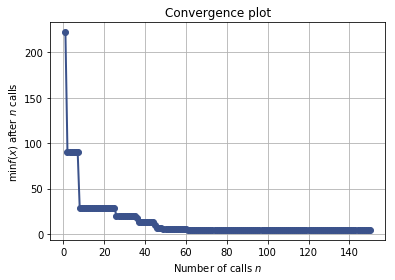

az_music_5core lda_pop 4.810422882773011


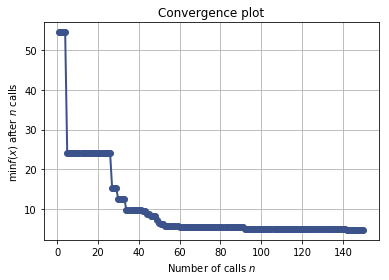

az_music_5core ibp_unif 9.218110656331309


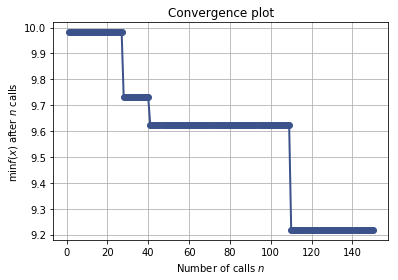

az_music_5core ibp_pop 10.313036663101945


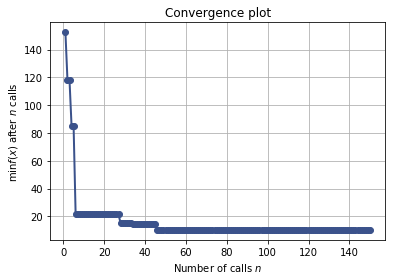

az_music_5core unif_unif 11.476317103638216


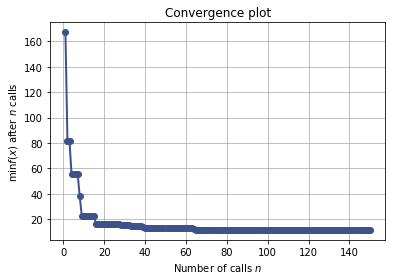

az_music_5core unif_pop 12.094139143957069


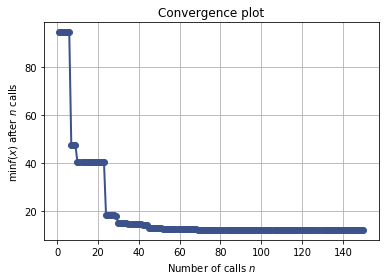

In [13]:
data = ['az_music_5core']
models = ['lda_unif', 'lda_pop', 'ibp_unif', 'ibp_pop', 'unif_unif', 'unif_pop']
for d in data:
    for m in models:   
        res_gp = skopt.load(f'build/skopt_{m}-{d}.pkl')
        print(d, m, res_gp.fun)
        with open(f'build/params_{m}-{d}.pkl', 'rb') as f:
            params = pickle.load(f)
        if 'lda' in m or 'unif_unif' in m or 'unif_pop' in m:
            assert params == [5541, 3568, *res_gp.x] 
        elif 'ibp' in m:
            assert params == [5541, *res_gp.x]
        plot_convergence(res_gp)
        plt.show()

In [14]:
def search_space(file):
    res_gp = skopt.load(file)
    if 'lda' in file:
        labels = ['k', 'lambda', 'a', 'b', 'm', 'alpha', 'upper']
    else:
        labels = ['alpha', 'c', 'sigma', 'm', 'alpha', 'upper']
    print(*zip(labels, zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)

## Amazon music instruments

### lda unif on user user

In [15]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_5core-ucorr-1-2019-04-11-13-58-03.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_5core-ucorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)

[(10.0, 200.0), (5.000000000000001, 499.99999999999994), (0.01, 1.0), (0.01, 1.0), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)] 0.0015656749318960887
[(5.0, 200.0), (5.000000000000001, 2000.0), (0.01, 1.0), (0.01, 1.0), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)] 0.0016214167064225655


[48, 28.524996213165974, 0.01, 0.01, 4.364879072073878, 1.7308880642589364, 462.40000000000015] 0.0016214167064225655
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  LDA-Unif    5541    2883   44501  0.002786
item popularity stats
              AZM5     LDA-Unif
count  3568.000000  2883.000000
mean     18.135090    15.435657
std      21.639818    16.113977
min       5.000000     1.000000
25%       6.000000     4.000000
50%      10.000000    10.000000
75%      20.000000    22.000000
max     272.000000   130.000000
user profile stats
              AZM5     LDA-Unif
count  5541.000000  5541.000000
mean     11.677676     8.031222
std      18.222800     5.068869
min       5.000000     4.000000
25%       5.000000     5.000000
50%       7.000000     6.000000
75%      11.000000     9.000000
max     578.000000    33.000000


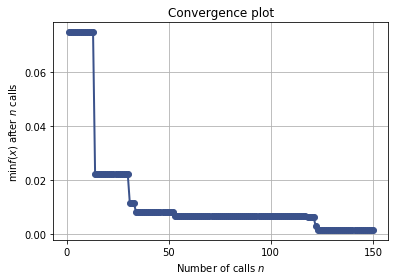

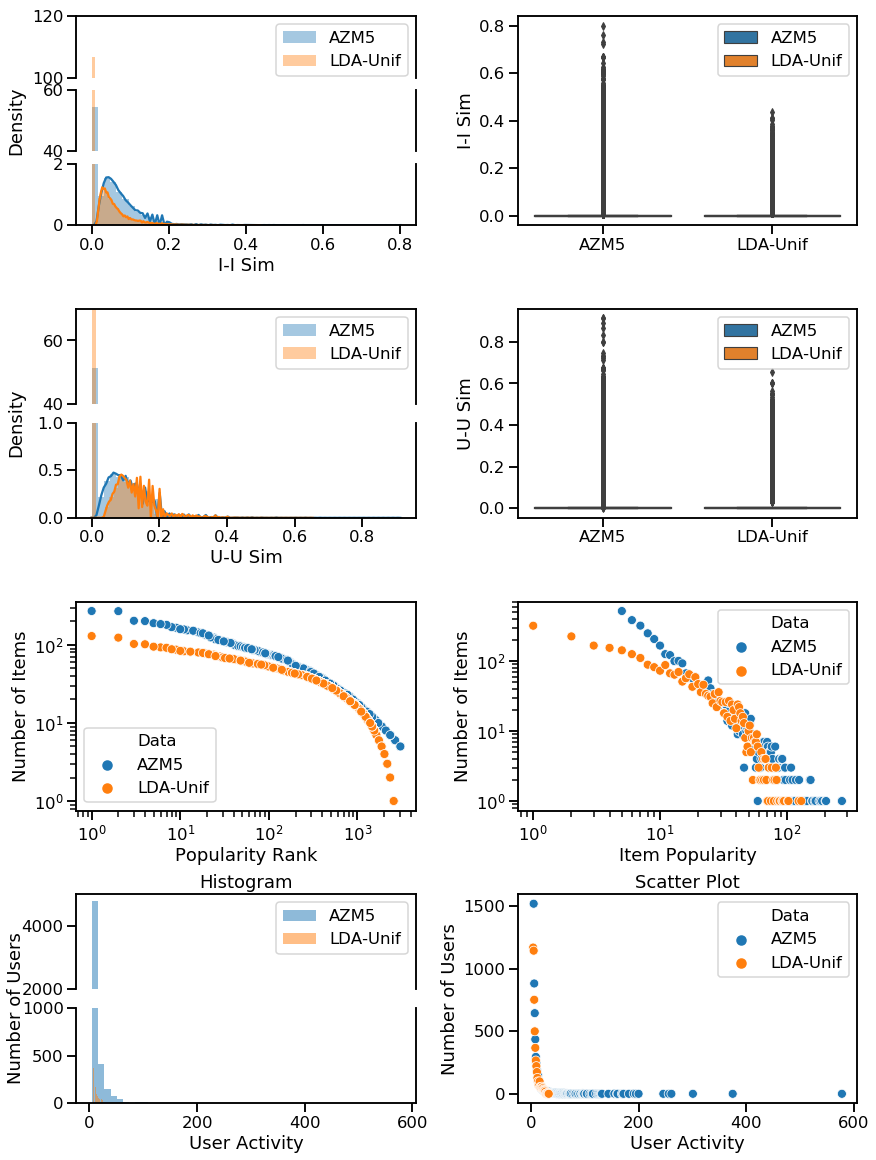

In [88]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_5core-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-az_music_5core-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', lda_unif_pareto), args=[5541, 3568, *res_gp.x, 'lda_unif_csr-az_music_5core-ucorr.pkl'],
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (50, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', simulated_data), mrated=5,
               ylim_left=((100, 120), (40, 60), (0, 2)), ylim_left2=((40, 70), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)))

### lda unif on item item

[5, 86.03368100858732, 0.0374628085151884, 0.01, 4.816591056365287, 1.7481603033636222, 693.5999999999997] 0.007589134125255041
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  LDA-Unif    5541     987   53260  0.009739
item popularity stats
              AZM5    LDA-Unif
count  3568.000000  987.000000
mean     18.135090   53.961499
std      21.639818   76.256204
min       5.000000    1.000000
25%       6.000000    3.000000
50%      10.000000   17.000000
75%      20.000000   71.500000
max     272.000000  479.000000
user profile stats
              AZM5     LDA-Unif
count  5541.000000  5541.000000
mean     11.677676     9.611983
std      18.222800     8.080303
min       5.000000     4.000000
25%       5.000000     5.000000
50%       7.000000     7.000000
75%      11.000000    10.000000
max     578.000000    66.000000


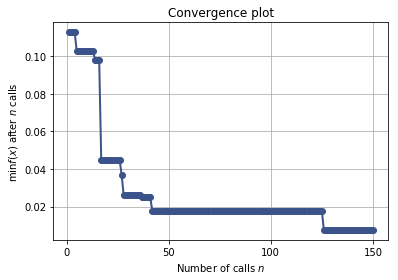

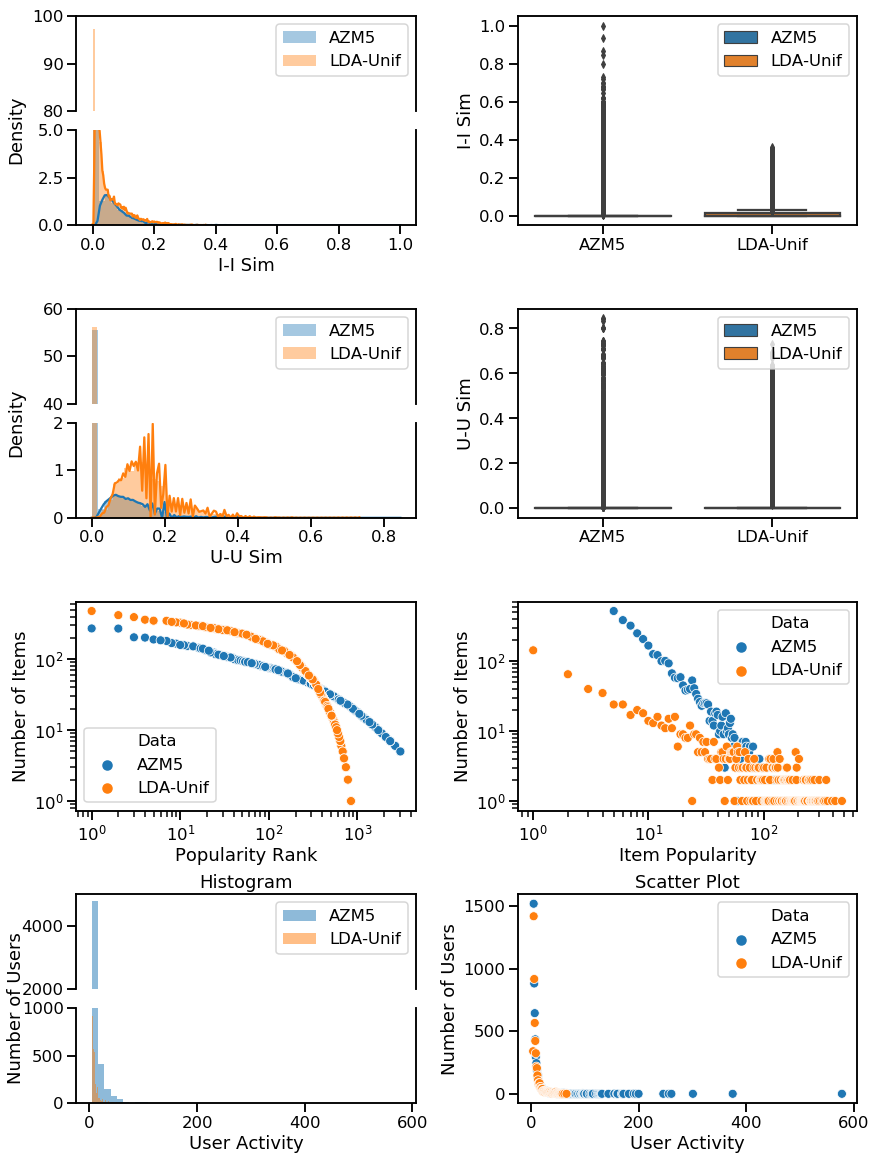

In [18]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_5core-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-az_music_5core-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', lda_unif_pareto), args=[5541, 3568, *res_gp.x, 'lda_unif_csr-az_music_5core-icorr.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', simulated_data), mrated=5,
               ylim_left=((80, 100), (0, 5)), ylim_left2=((40, 60), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)))

### lda unif on item pop

[180, 29.211249215324194, 0.1518924513459123, 0.01, 5.043800871451375, 1.5682912937730704, 472.3915480414272] 0.38904718559667545
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  LDA-Unif    5541    3504   55603  0.002864
item popularity stats
              AZM5     LDA-Unif
count  3568.000000  3504.000000
mean     18.135090    15.868436
std      21.639818    11.526315
min       5.000000     1.000000
25%       6.000000     7.000000
50%      10.000000    13.000000
75%      20.000000    22.000000
max     272.000000    79.000000
user profile stats
              AZM5     LDA-Unif
count  5541.000000  5541.000000
mean     11.677676    10.034831
std      18.222800     6.634206
min       5.000000     5.000000
25%       5.000000     6.000000
50%       7.000000     7.000000
75%      11.000000    12.000000
max     578.000000    43.000000


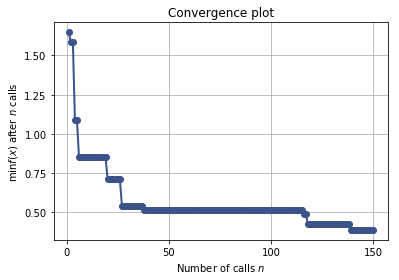

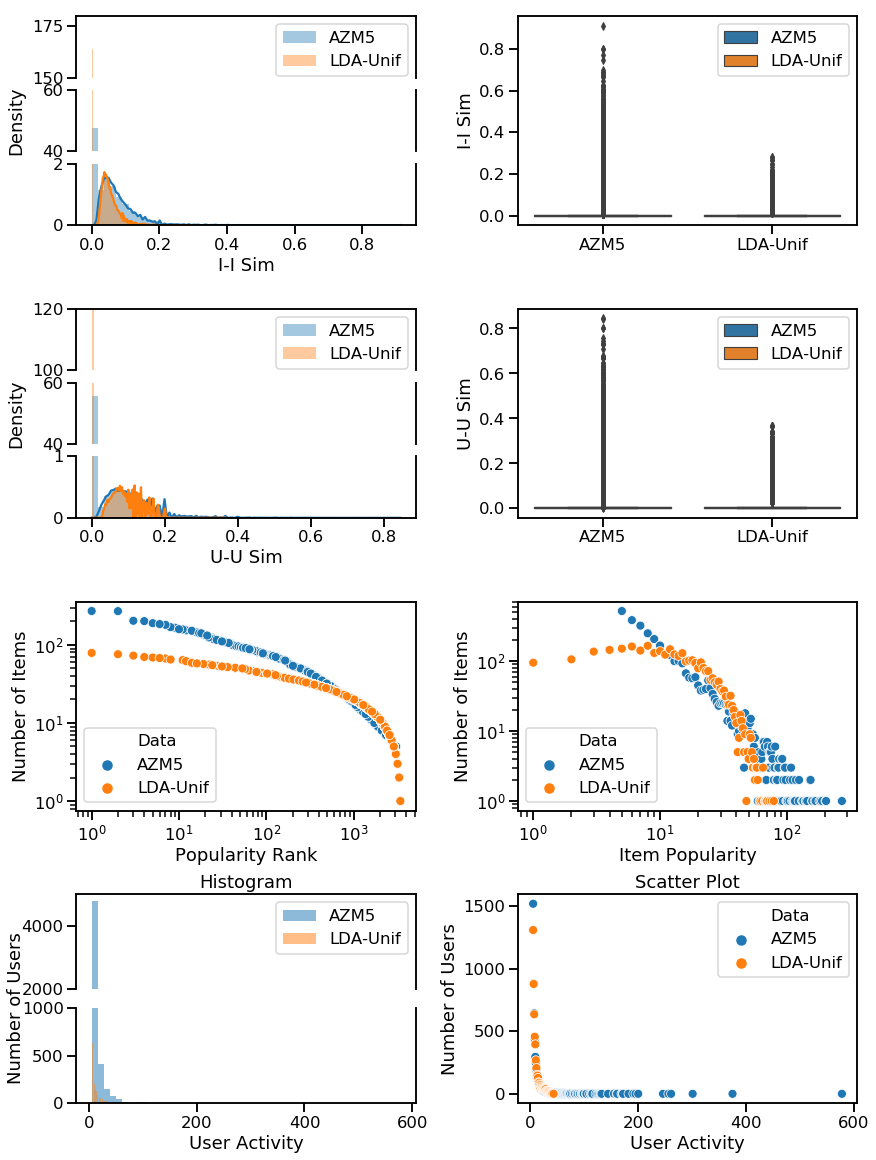

In [25]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_5core-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-az_music_5core-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azm5core', az_music_5core), ('lda_unif', lda_unif_pareto), args=[5541, 3568, *res_gp.x, 'lda_unif_csr-az_music_5core-item-pop.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)))
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', simulated_data),
               ylim_left=((150, 180), (40, 60), (0, 2)), ylim_left2=((100, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### lda unif on user activity

[200, 111.91473736891534, 0.20302715962797963, 0.01055308343526227, 5.020638952336301, 1.6736055099539076, 482.82582138398834] 0.026133097071747456
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  LDA-Unif    5541    3533   61131  0.003123
item popularity stats
              AZM5     LDA-Unif
count  3568.000000  3533.000000
mean     18.135090    17.302859
std      21.639818    11.645139
min       5.000000     1.000000
25%       6.000000     9.000000
50%      10.000000    15.000000
75%      20.000000    24.000000
max     272.000000    81.000000
user profile stats
              AZM5     LDA-Unif
count  5541.000000  5541.000000
mean     11.677676    11.032485
std      18.222800    12.544636
min       5.000000     5.000000
25%       5.000000     5.000000
50%       7.000000     7.000000
75%      11.000000    11.000000
max     578.000000   129.000000


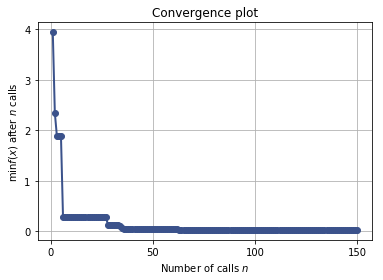

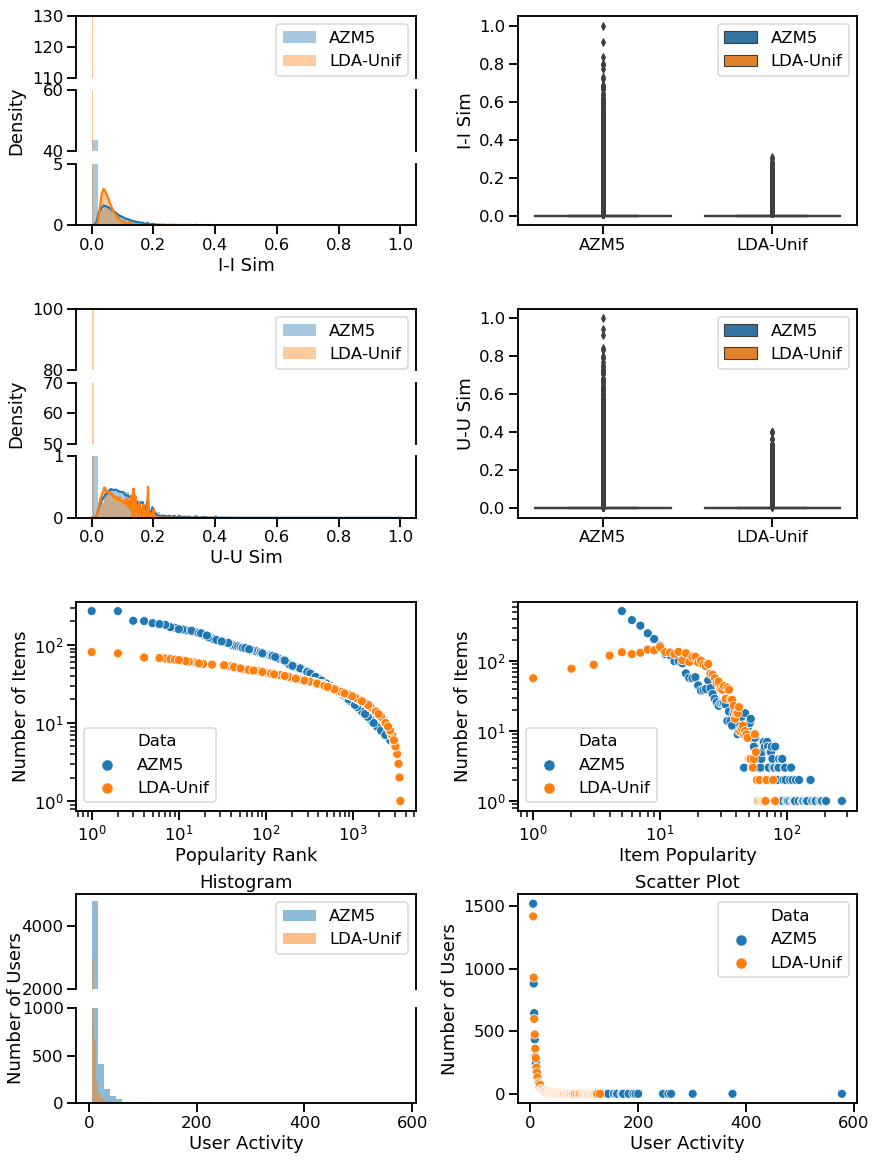

In [26]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_5core-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif_csr-az_music_5core-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azm5core', az_music_5core), ('lda_unif', lda_unif_pareto), args=[5541, 3568, *res_gp.x, 'lda_unif_csr-az_music_5core-user-act.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)))
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', simulated_data),
               ylim_left=((110, 130), (40, 60), (0, 5)), ylim_left2=((80, 100), (50, 70), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### lda unif on relative loss

In [17]:
res_gp = skopt.load('build/gp_minimize_lda_unif_csr-az_music_5core-ucorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))
res_gp = skopt.load('build/skopt_lda_unif-az_music_5core.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))

[(5.0, 200.0), (5.000000000000001, 2000.0), (0.01, 1.0), (0.01, 1.0), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)]
[(5.0, 200.0), (5.000000000000001, 2000.0), (0.01, 1.0), (0.01, 1.0), (4.0, 6.0), (0.1, 19.311532937582705), (50.0, 693.5999999999997)]


In [27]:
from simulation_utils.datasets import ml_1m, steam_video_game

In [28]:
data = steam_video_game()
ua = data.groupby('user')['item'].count().values

In [29]:
len(ua) * 0.0001

7.091200000000001

In [31]:
np.percentile(ua, 99.9)

1445.1570000000938

[24, 96.75714693571486, 0.01, 0.01, 5.549031845451039, 1.732364807385344, 375.6637249569422] 4.609133998002625
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  LDA-Unif    5541    2477   61507  0.004481
item popularity stats
              AZM5     LDA-Unif
count  3568.000000  2477.000000
mean     18.135090    24.831247
std      21.639818    26.564196
min       5.000000     1.000000
25%       6.000000     4.000000
50%      10.000000    15.000000
75%      20.000000    38.000000
max     272.000000   187.000000
user profile stats
              AZM5     LDA-Unif
count  5541.000000  5541.000000
mean     11.677676    11.100343
std      18.222800     9.058437
min       5.000000     5.000000
25%       5.000000     6.000000
50%       7.000000     8.000000
75%      11.000000    12.000000
max     578.000000    76.000000


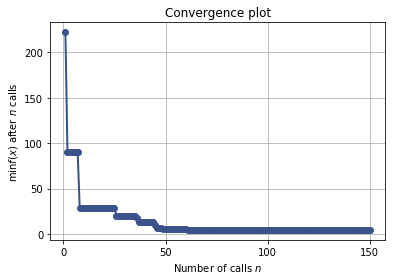

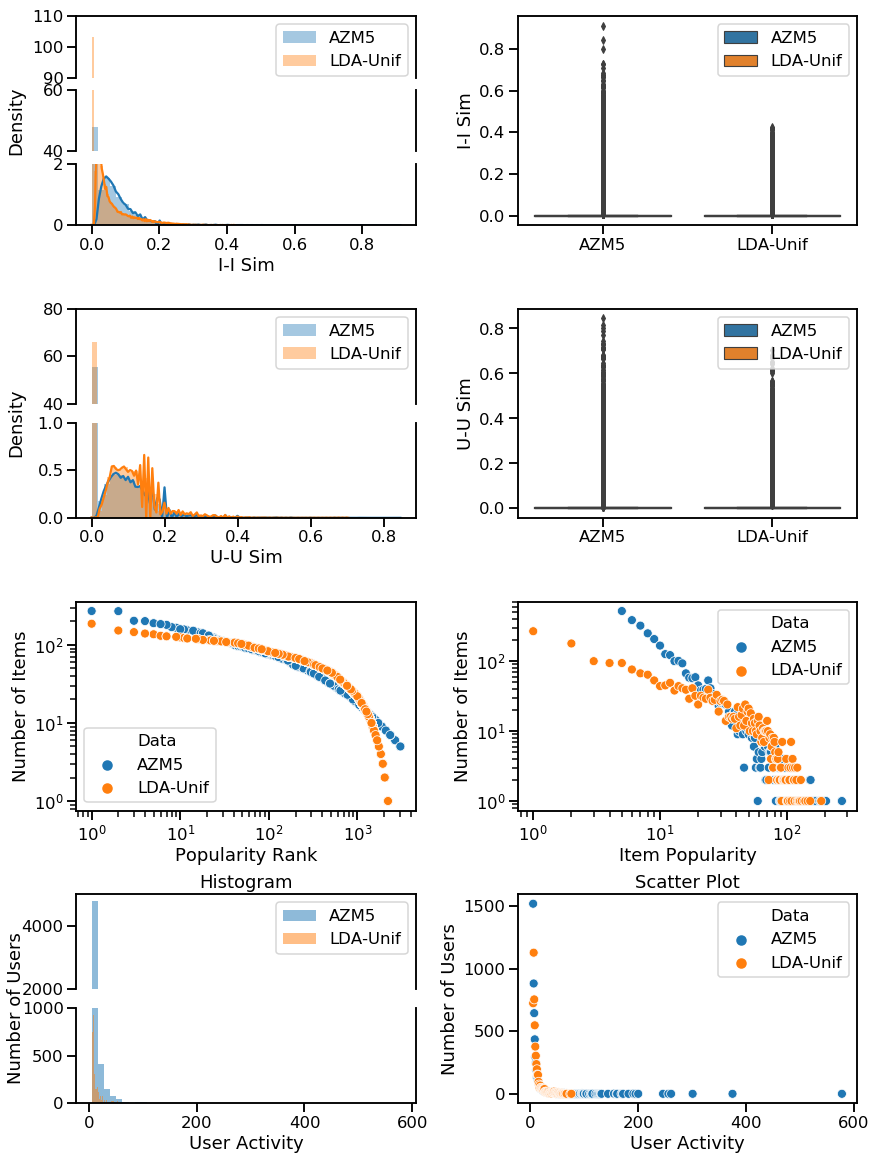

In [36]:
res_gp = skopt.load('build/skopt_lda_unif-az_music_5core.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_unif-az_music_5core.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', lda_unif_pareto), args=[5541, 3568, *res_gp.x, 'lda_unif-az_music_5core.pkl'],
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (40, 50), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)))
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Unif', simulated_data),
               ylim_left=((90, 110), (40, 60), (0, 2)), ylim_left2=((40, 80), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### lda pop on item item

[5, 42.10608215075549, 0.01, 0.01, 6.0, 9.040954566880707, 672.1812470732925] 0.0015090681167224517
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  LDA-Pop    5541     523   35348  0.012198
item popularity stats
              AZM5     LDA-Pop
count  3568.000000  523.000000
mean     18.135090   67.586998
std      21.639818  103.513514
min       5.000000    1.000000
25%       6.000000    3.000000
50%      10.000000   18.000000
75%      20.000000   90.500000
max     272.000000  530.000000
user profile stats
              AZM5      LDA-Pop
count  5541.000000  5541.000000
mean     11.677676     6.379354
std      18.222800     0.813980
min       5.000000     6.000000
25%       5.000000     6.000000
50%       7.000000     6.000000
75%      11.000000     7.000000
max     578.000000    18.000000


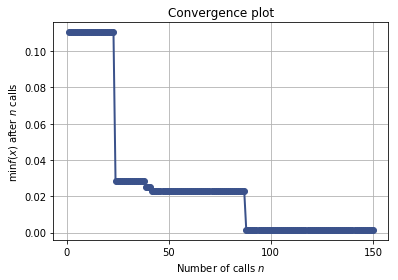

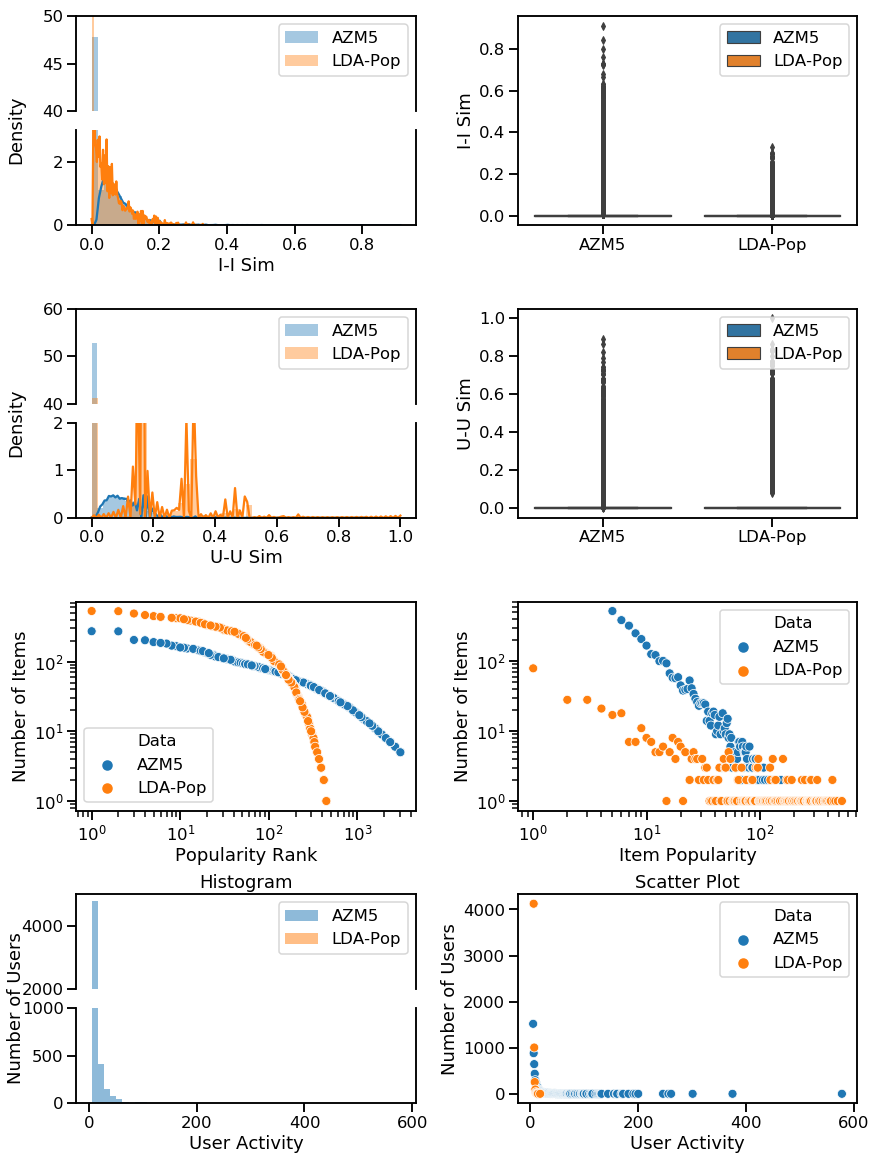

In [37]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_5core-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-az_music_5core-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('lda_pop', lda_pop_pareto), args=[5541, 3568, *res_gp.x, 'lda_pop_csr-az_music_5core-icorr.pkl'],
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (40, 50), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Pop', simulated_data),
               ylim_left=((40, 50), (0, 3)), ylim_left2=((40, 60), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### lda pop on user user

In [22]:
search_space('build/gp_minimize_lda_pop_csr-az_music_5core-ucorr-1-2019-04-11-14-45-34.pkl')
search_space('build/gp_minimize_lda_pop_csr-az_music_5core-ucorr.pkl')

[(10.0, 200.0), (5.000000000000001, 499.99999999999994), (0.01, 1.0), (0.01, 1.0), (4.5, 5.5), (0.1, 20.0), (520.2, 635.7999999999997)] 0.010578844407035702
[(5.0, 200.0), (5.000000000000001, 2000.0), (0.01, 1.0), (0.01, 1.0), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)] 0.004527797738577112


[5, 512.1977972503128, 0.01, 0.25652930398024354, 4.0, 2.0260505856452844, 578.7903644907719] 0.004527797738577112
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  LDA-Pop    5541    2962   41247  0.002513
item popularity stats
              AZM5      LDA-Pop
count  3568.000000  2962.000000
mean     18.135090    13.925388
std      21.639818    15.934691
min       5.000000     1.000000
25%       6.000000     3.000000
50%      10.000000     8.000000
75%      20.000000    19.000000
max     272.000000   137.000000
user profile stats
              AZM5      LDA-Pop
count  5541.000000  5541.000000
mean     11.677676     7.443963
std      18.222800    10.028622
min       5.000000     4.000000
25%       5.000000     4.000000
50%       7.000000     5.000000
75%      11.000000     7.000000
max     578.000000   348.000000


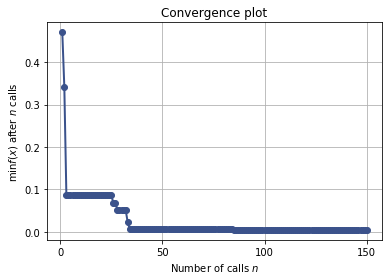

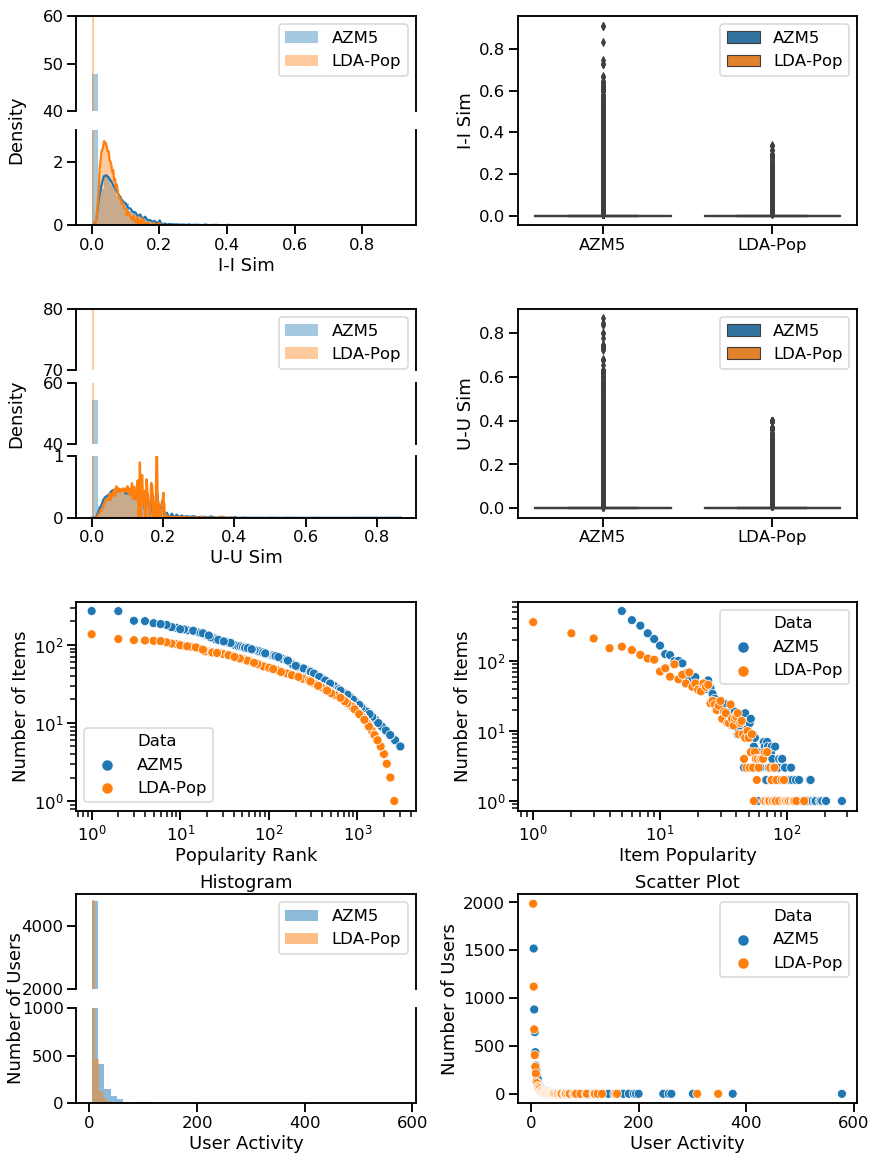

In [38]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_5core-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-az_music_5core-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('lda_pop', lda_pop_pareto), args=[5541, 3568, *res_gp.x, 'lda_pop_csr-az_music_5core-ucorr.pkl'],
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (40, 50), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Pop', simulated_data),
               ylim_left=((40, 60), (0, 3)), ylim_left2=((70, 80), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### lda pop on item pop

[5, 11.411604200501259, 0.9616803335459548, 0.4519974209697948, 4.938529814786985, 0.21575206774096406, 693.5999999999997] 0.38743013596160125
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  LDA-Pop    5541    3519   56003  0.002872
item popularity stats
              AZM5      LDA-Pop
count  3568.000000  3519.000000
mean     18.135090    15.914464
std      21.639818    12.095945
min       5.000000     1.000000
25%       6.000000     7.000000
50%      10.000000    13.000000
75%      20.000000    22.000000
max     272.000000    84.000000
user profile stats
              AZM5      LDA-Pop
count  5541.000000  5541.000000
mean     11.677676    10.107020
std      18.222800     3.459918
min       5.000000     1.000000
25%       5.000000     7.000000
50%       7.000000    10.000000
75%      11.000000    12.000000
max     578.000000    25.000000


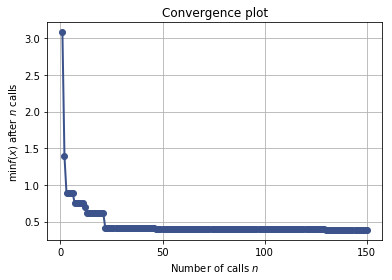

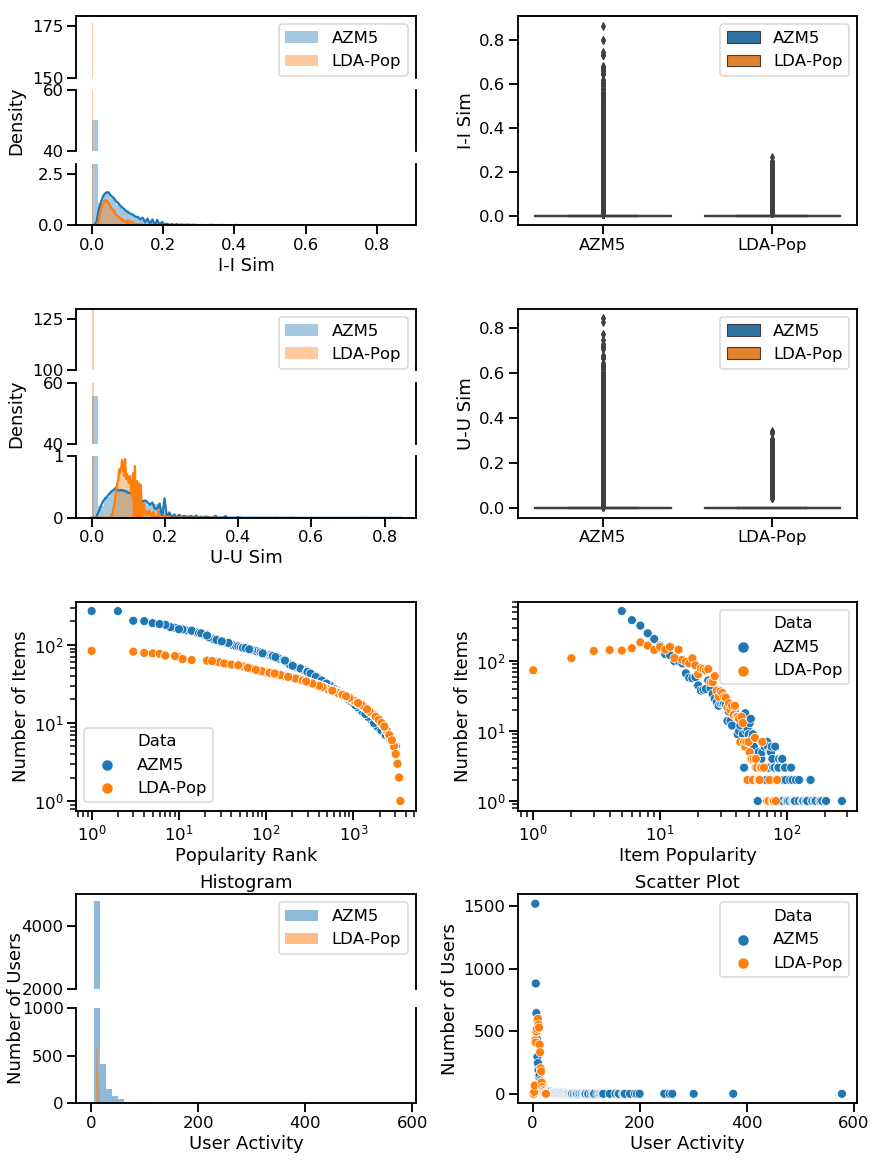

In [47]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_5core-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-az_music_5core-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('lda_pop', lda_pop_pareto), args=[5541, 3568, *res_gp.x, 'lda_pop_csr-az_music_5core-item-pop.pkl'],
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (40, 50), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Pop', simulated_data),
               ylim_left=((150, 180), (40, 60), (0, 3)), ylim_left2=((100, 130), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### lda pop on user activity

[200, 289.25129451801666, 1.0, 0.4368817507856265, 5.094097439037924, 1.660915380509952, 635.3720339183204] 0.030368234301040443
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  LDA-Pop    5541    3568   64255  0.003250
item popularity stats
              AZM5      LDA-Pop
count  3568.000000  3568.000000
mean     18.135090    18.008688
std      21.639818     5.656030
min       5.000000     3.000000
25%       6.000000    14.000000
50%      10.000000    18.000000
75%      20.000000    22.000000
max     272.000000    41.000000
user profile stats
              AZM5      LDA-Pop
count  5541.000000  5541.000000
mean     11.677676    11.596282
std      18.222800    17.690867
min       5.000000     5.000000
25%       5.000000     6.000000
50%       7.000000     7.000000
75%      11.000000    11.000000
max     578.000000   317.000000


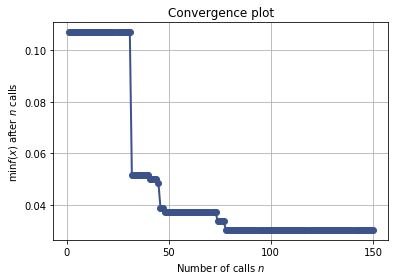

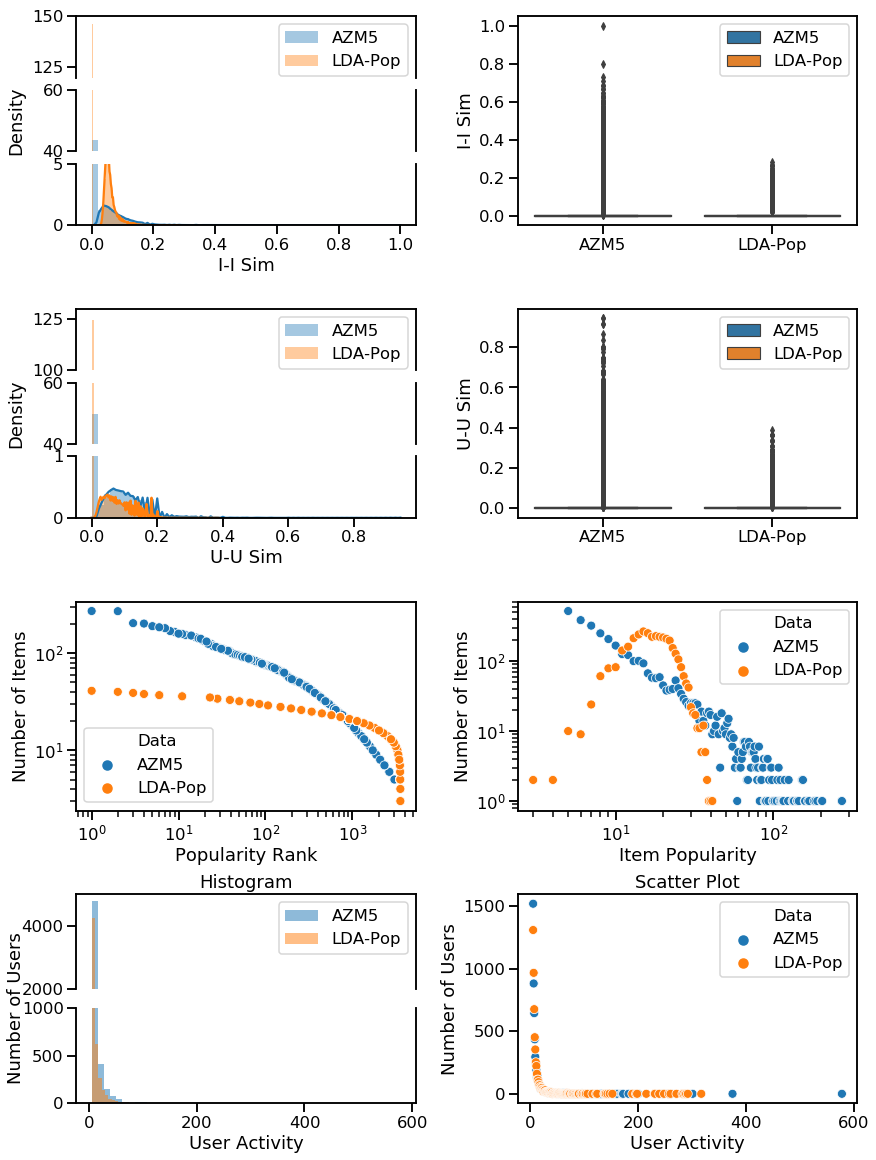

In [52]:
res_gp = skopt.load('build/gp_minimize_lda_pop_csr-az_music_5core-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop_csr-az_music_5core-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('lda_pop', lda_pop_pareto), args=[5541, 3568, *res_gp.x, 'lda_pop_csr-az_music_5core-user-act.pkl'],
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (40, 50), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Pop', simulated_data),
               ylim_left=((120, 150), (40, 60), (0, 5)), ylim_left2=((100, 130), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### lda pop on relative loss

[138, 415.8439312001103, 0.01, 0.01, 5.207195803297304, 1.7442983520551985, 693.5999999999997] 4.810422882773011
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  LDA-Pop    5541    3347   60994  0.003289
item popularity stats
              AZM5      LDA-Pop
count  3568.000000  3347.000000
mean     18.135090    18.223484
std      21.639818    17.650106
min       5.000000     1.000000
25%       6.000000     6.000000
50%      10.000000    13.000000
75%      20.000000    25.000000
max     272.000000   148.000000
user profile stats
              AZM5      LDA-Pop
count  5541.000000  5541.000000
mean     11.677676    11.007760
std      18.222800    13.380428
min       5.000000     5.000000
25%       5.000000     6.000000
50%       7.000000     7.000000
75%      11.000000    11.000000
max     578.000000   202.000000


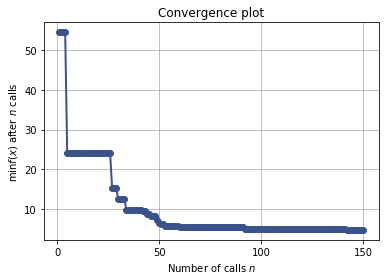

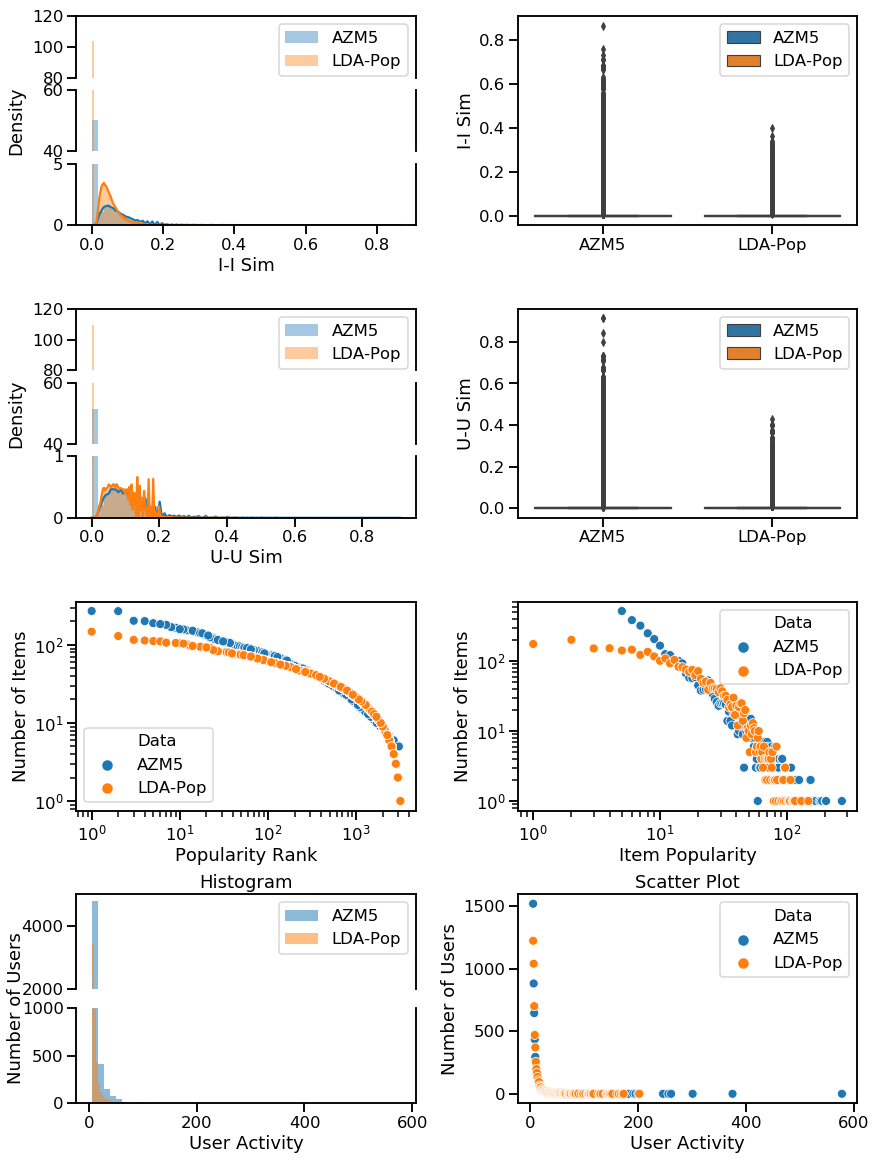

In [58]:
res_gp = skopt.load('build/skopt_lda_pop-az_music_5core.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/lda_pop-az_music_5core.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('AZM5', az_music_5core), ('LDA-Pop', lda_unif_pareto), args=[5541, 3568, *res_gp.x, 'lda_pop-az_music_5core.pkl'])
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('LDA-Pop', simulated_data),
               ylim_left=((80, 120), (40, 60), (0, 5)), ylim_left2=((80, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp unif on item item

In [26]:
search_space('build/gp_minimize_ibp_unif_csr-az_music_5core-icorr-1-2019-04-11-14-46-18.pkl')
search_space('build/gp_minimize_ibp_unif_csr-az_music_5core-icorr.pkl')

[(20.000000000000004, 499.99999999999994), (0.01, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)] 0.007687366741470387
[(10.0, 906.4105495035097), (0.01, 93.66321814103694), (0.0, 0.9888854342292578), (4.0, 5.908705993034034), (0.1, 19.952084069714076), (462.40000000000015, 693.2734320308183)] 0.0163127802296555


[534.0877999037211, 0.30906506558297936, 0.9536593263773088, 4.297539198719376, 1.7676225334184323, 539.0007749757009] 0.0163127802296555
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  IBP-Unif    5541   41917   50777  0.000219
item popularity stats
              AZM5      IBP-Unif
count  3568.000000  41917.000000
mean     18.135090      1.211370
std      21.639818      2.203748
min       5.000000      1.000000
25%       6.000000      1.000000
50%      10.000000      1.000000
75%      20.000000      1.000000
max     272.000000    107.000000
user profile stats
              AZM5     IBP-Unif
count  5541.000000  5541.000000
mean     11.677676     9.163869
std      18.222800    13.841112
min       5.000000     4.000000
25%       5.000000     5.000000
50%       7.000000     6.000000
75%      11.000000     9.000000
max     578.000000   502.000000


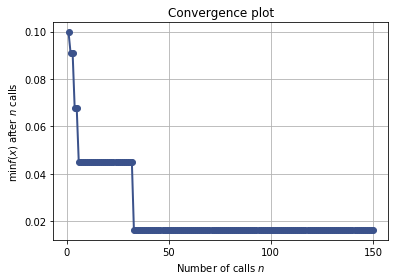

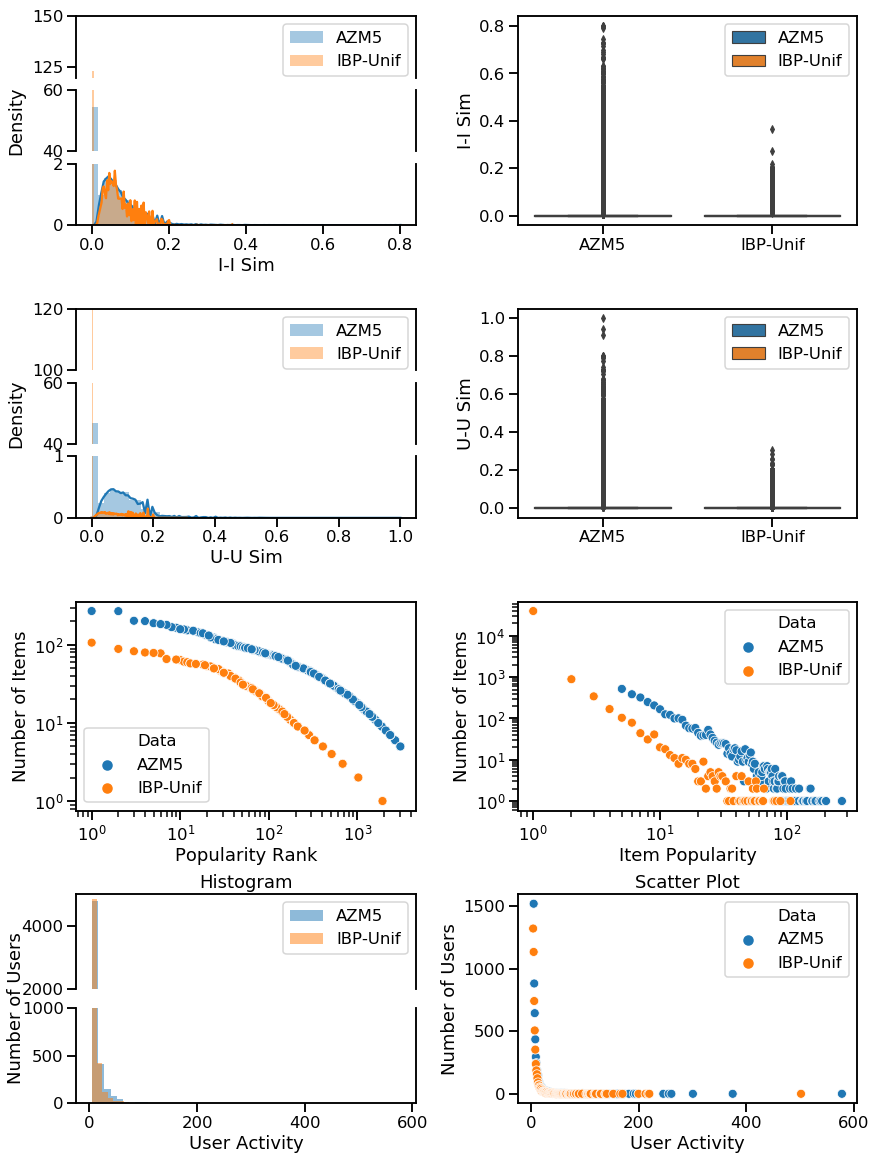

In [63]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_5core-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-az_music_5core-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_unif', ibp_unif_pareto), args=[5541, *res_gp.x, 'ibp_unif_csr-az_music_5core-icorr.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Unif', simulated_data),
               ylim_left=((120, 150), (40, 60), (0, 2)), ylim_left2=((100, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp unif on user user

In [30]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_5core-ucorr-1-2019-04-11-14-46-12.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)
res_gp = skopt.load('build/skopt_ibp_unif-az_music_5core.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_5core-ucorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)

[(20.000000000000004, 499.99999999999994), (0.01, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)] 0.005630515542353882
[(10.219507337475969, 922.9888379712951), (0.014787004017257384, 94.25011498507287), (0.0005146704311722485, 0.9155588132176941), (4.085243809958562, 5.897479228396728), (0.37232112302137155, 19.926392983306584), (465.0040287903868, 692.1331335993211)] 17.189560519229367
[(10.0, 1000.0), (0.01, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)] 0.004762849144961284


[100.32396772261413, 7.156597426422489, 0.31414336610913185, 4.219765735582276, 2.0463480711493744, 564.0353468803717] 0.004762849144961284
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  IBP-Unif    5541    6082   42460  0.001260
item popularity stats
              AZM5     IBP-Unif
count  3568.000000  6082.000000
mean     18.135090     6.981256
std      21.639818    14.711421
min       5.000000     1.000000
25%       6.000000     1.000000
50%      10.000000     2.000000
75%      20.000000     6.000000
max     272.000000   228.000000
user profile stats
              AZM5     IBP-Unif
count  5541.000000  5541.000000
mean     11.677676     7.662877
std      18.222800     7.639724
min       5.000000     4.000000
25%       5.000000     4.000000
50%       7.000000     5.000000
75%      11.000000     8.000000
max     578.000000   108.000000


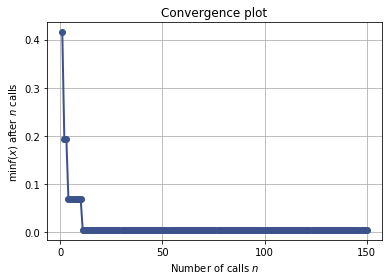

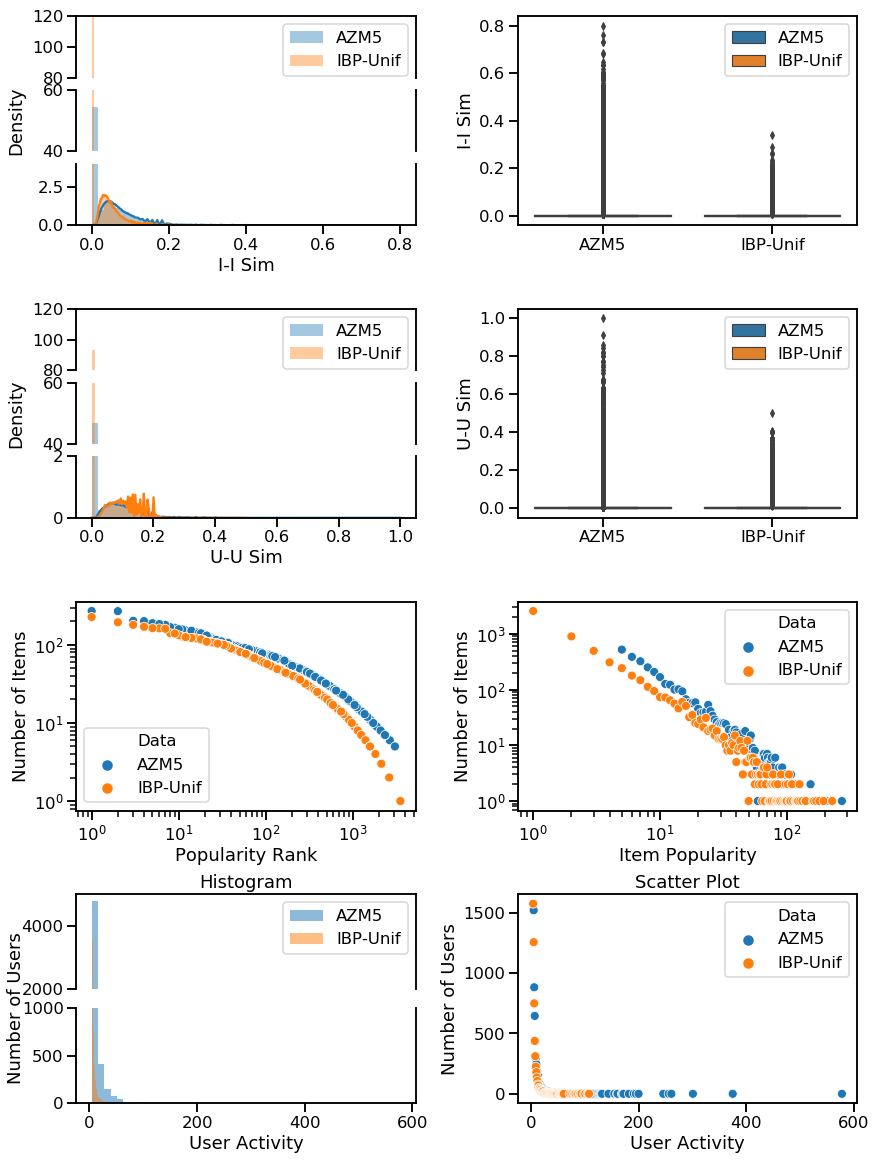

In [64]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_5core-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-az_music_5core-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_unif', ibp_unif_pareto), args=[5541, *res_gp.x, 'ibp_unif_csr-az_music_5core-ucorr.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Unif', simulated_data),
               ylim_left=((80, 120), (40, 60), (0, 4)), ylim_left2=((80, 120), (40, 60), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp unif on item pop

[16.596561539641364, 46.964991285824176, 0.0, 6.0, 0.1, 693.5999999999997] 0.7660324767478874
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  IBP-Unif    5541    3547   80861  0.004114
item popularity stats
              AZM5     IBP-Unif
count  3568.000000  3547.000000
mean     18.135090    22.797012
std      21.639818    42.495671
min       5.000000     1.000000
25%       6.000000     2.000000
50%      10.000000     6.000000
75%      20.000000    23.000000
max     272.000000   517.000000
user profile stats
              AZM5     IBP-Unif
count  5541.000000  5541.000000
mean     11.677676    14.593214
std      18.222800     4.676176
min       5.000000     5.000000
25%       5.000000    11.000000
50%       7.000000    15.000000
75%      11.000000    18.000000
max     578.000000    31.000000


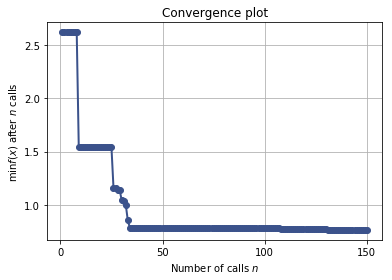

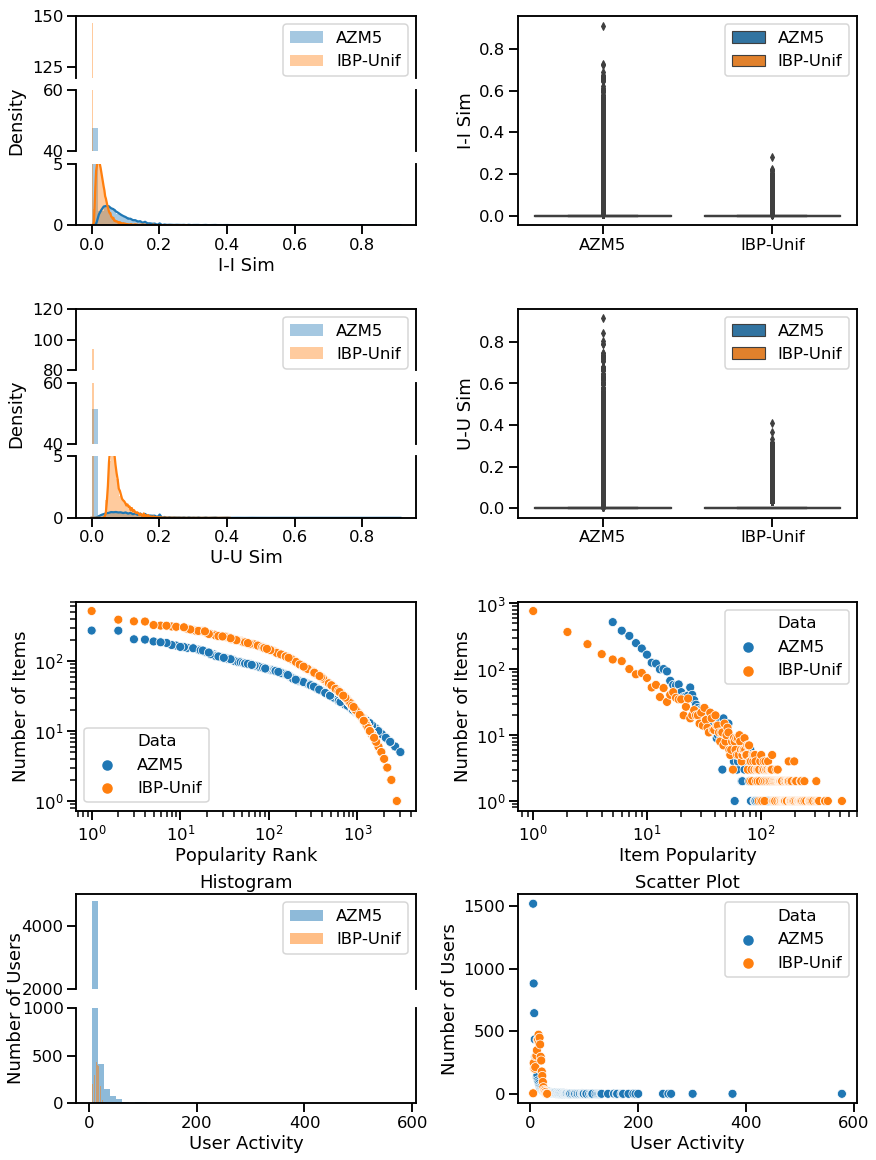

In [68]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_5core-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-az_music_5core-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_unif', ibp_unif_pareto), args=[5541, *res_gp.x, 'ibp_unif_csr-az_music_5core-item-pop.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Unif', simulated_data),
               ylim_left=((120, 150), (40, 60), (0, 5)), ylim_left2=((80, 120), (40, 60), (0, 5)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp unif on user activity

[110.0523881467792, 100.0, 0.7179396251381674, 4.999628915954799, 1.6691062291652197, 511.88830242796126] 0.02907331613572607
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  IBP-Unif    5541   42848   59288  0.000250
item popularity stats
              AZM5      IBP-Unif
count  3568.000000  42848.000000
mean     18.135090      1.383682
std      21.639818      1.214082
min       5.000000      1.000000
25%       6.000000      1.000000
50%      10.000000      1.000000
75%      20.000000      1.000000
max     272.000000     24.000000
user profile stats
              AZM5     IBP-Unif
count  5541.000000  5541.000000
mean     11.677676    10.699874
std      18.222800    11.545327
min       5.000000     5.000000
25%       5.000000     5.000000
50%       7.000000     7.000000
75%      11.000000    11.000000
max     578.000000   122.000000


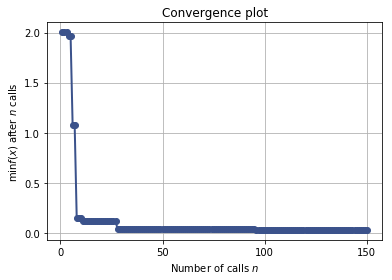

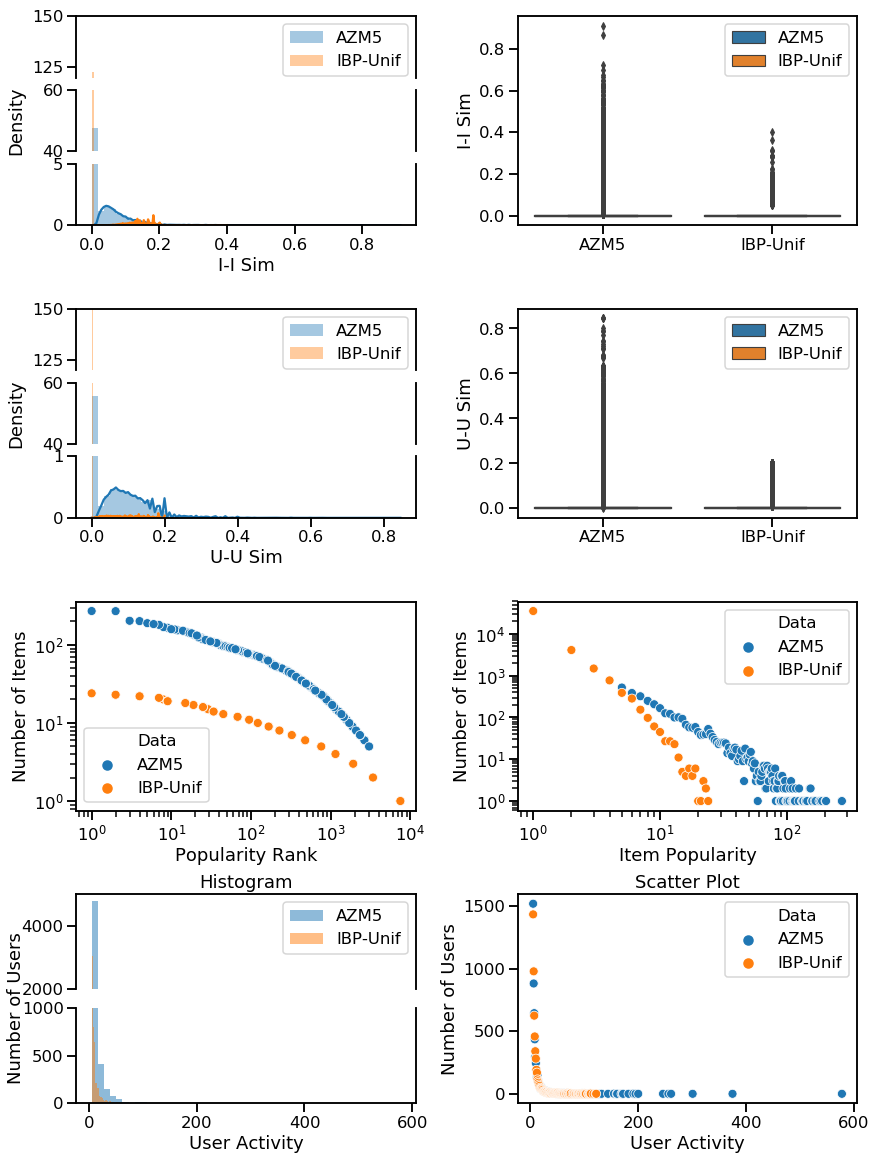

In [72]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_5core-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif_csr-az_music_5core-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_unif', ibp_unif_pareto), args=[5541, *res_gp.x, 'ibp_unif_csr-az_music_5core-user-act.pkl'],
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (40, 50), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Unif', simulated_data),
               ylim_left=((120, 150), (40, 60), (0, 5)), ylim_left2=((120, 150), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp unif on relative loss

In [34]:
res_gp = skopt.load('build/gp_minimize_ibp_unif_csr-az_music_5core-ucorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)
res_gp = skopt.load('build/skopt_ibp_unif-az_music_5core.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))), res_gp.fun)

[(10.0, 1000.0), (0.01, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)] 0.004762849144961284
[(10.219507337475969, 922.9888379712951), (0.014787004017257384, 94.25011498507287), (0.0005146704311722485, 0.9155588132176941), (4.085243809958562, 5.897479228396728), (0.37232112302137155, 19.926392983306584), (465.0040287903868, 692.1331335993211)] 17.189560519229367


[164.2941865542456, 3.463619562871001, 0.745974610922407, 5.514983689168458, 1.8665727852862695, 693.5999999999997] 9.218110656331309
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  IBP-Unif    5541   25695   61862  0.000434
item popularity stats
              AZM5      IBP-Unif
count  3568.000000  25695.000000
mean     18.135090      2.407550
std      21.639818      6.587208
min       5.000000      1.000000
25%       6.000000      1.000000
50%      10.000000      1.000000
75%      20.000000      1.000000
max     272.000000    183.000000
user profile stats
              AZM5     IBP-Unif
count  5541.000000  5541.000000
mean     11.677676    11.164411
std      18.222800    12.576978
min       5.000000     5.000000
25%       5.000000     6.000000
50%       7.000000     8.000000
75%      11.000000    11.000000
max     578.000000   168.000000


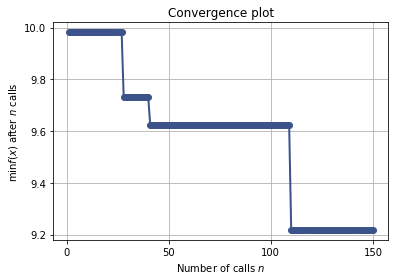

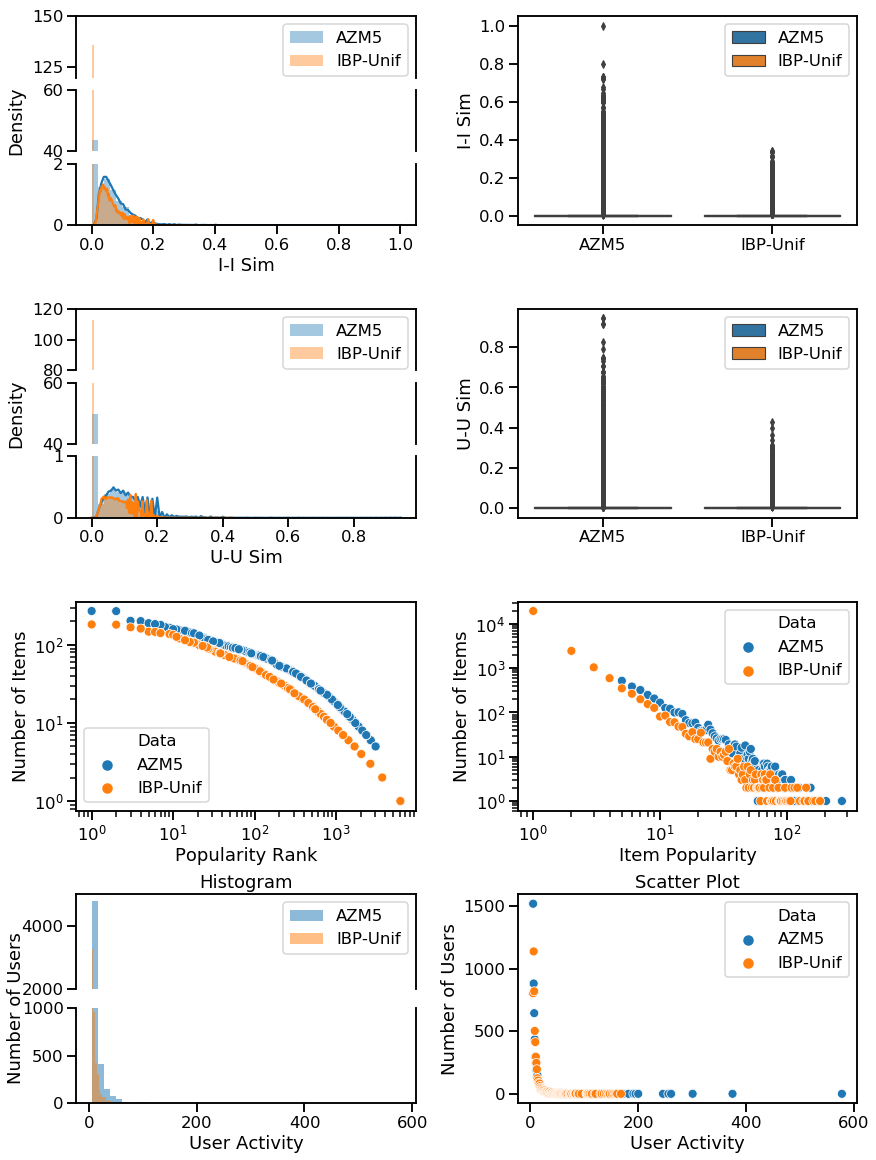

In [78]:
res_gp = skopt.load('build/skopt_ibp_unif-az_music_5core.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_unif-az_music_5core.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('AZM5', az_music_5core), ('IBP-Unif', ibp_unif_pareto), args=[5541, *res_gp.x, 'ibp_unif-az_music_5core.pkl'], mrated=5,
               ylim_left=((40, 50), (0, 2)), ylim_left2=((70, 80), (40, 50), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)))
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Unif', simulated_data), mrated=5,
               ylim_left=((120, 150), (40, 60), (0, 2)), ylim_left2=((80, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)))

### ibp pop on item item

In [36]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-icorr-1-2019-04-11-14-46-42.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-icorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))

[(20.000000000000004, 499.99999999999994), (0.01, 100.0), (0.0, 0.99), (4.5, 5.5), (0.1, 20.0), (520.2, 635.7999999999997)]
[(10.0, 1000.0), (0.01, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)]


[39.983074165393, 0.14029201312671688, 0.5839050583654597, 6.0, 20.0, 482.3373553605152] 0.005351511850929899
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  IBP-Pop    5541     347   33521  0.017434
item popularity stats
              AZM5      IBP-Pop
count  3568.000000   347.000000
mean     18.135090    96.602305
std      21.639818   314.693130
min       5.000000     1.000000
25%       6.000000     1.000000
50%      10.000000     6.000000
75%      20.000000    39.000000
max     272.000000  3162.000000
user profile stats
              AZM5      IBP-Pop
count  5541.000000  5541.000000
mean     11.677676     6.049630
std      18.222800     0.232453
min       5.000000     6.000000
25%       5.000000     6.000000
50%       7.000000     6.000000
75%      11.000000     6.000000
max     578.000000     9.000000


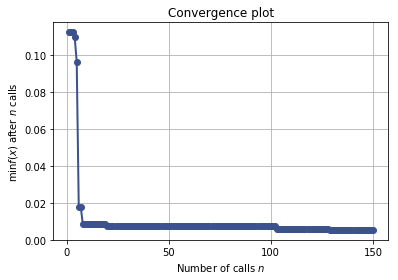

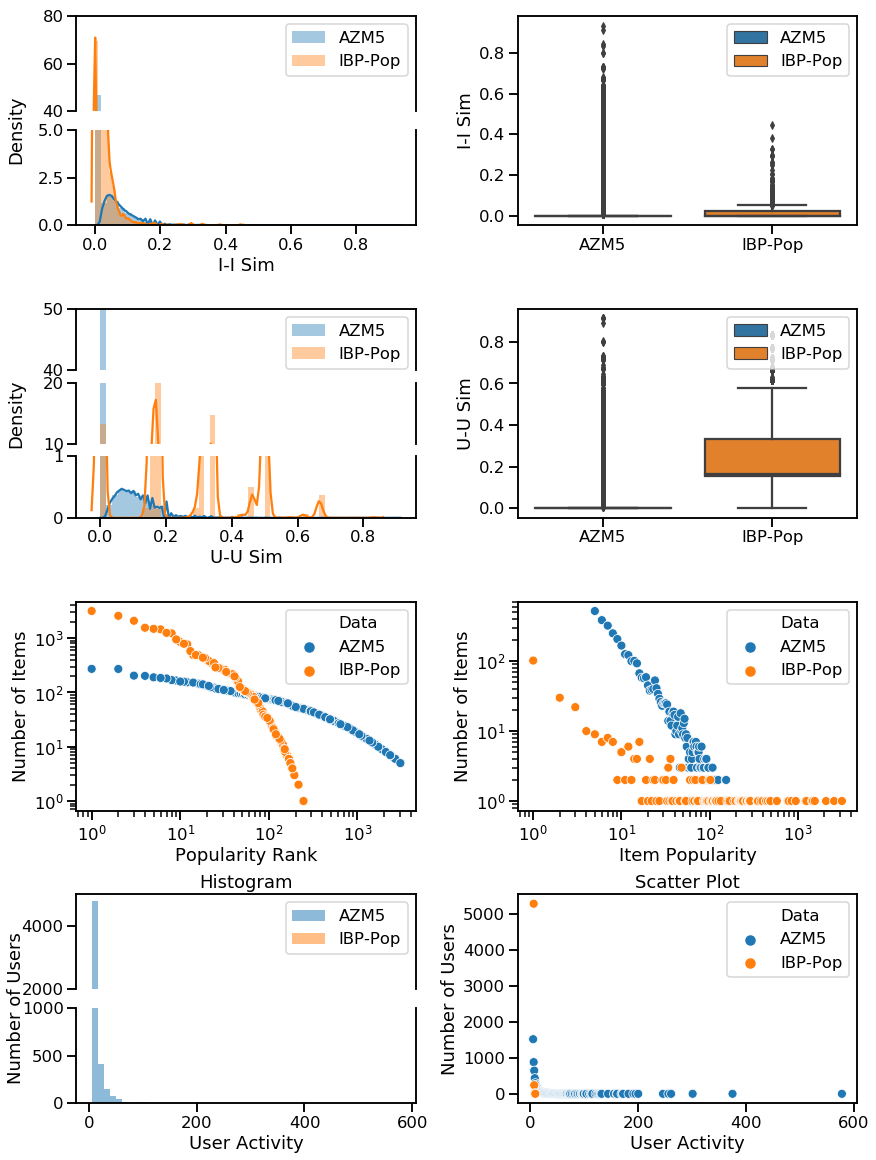

In [82]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-icorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-az_music_5core-icorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_pop', ibp_pop_pareto), args=[5541, *res_gp.x, 'ibp_pop_csr-az_music_5core-icorr.pkl'],
               ylim_left=((40, 50), (0, 10)), ylim_left2=((70, 80), (40, 50), (0, 10)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Pop', simulated_data),
               ylim_left=((40, 80), (0, 5)), ylim_left2=((40, 50), (10, 20), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp pop on user user

In [38]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-ucorr-1-2019-04-11-14-46-35.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-ucorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))

[(20.000000000000004, 499.99999999999994), (0.01, 100.0), (0.0, 0.99), (4.5, 5.5), (0.1, 20.0), (520.2, 635.7999999999997)]
[(10.0, 1000.0), (0.01, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)]


[66.02094407367188, 73.19394859861443, 0.5887799191202725, 4.329813937909652, 1.5416101503024013, 519.4895366102304] 0.00483450691298922
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  IBP-Pop    5541   12685   55488  0.000789
item popularity stats
              AZM5       IBP-Pop
count  3568.000000  12685.000000
mean     18.135090      4.374300
std      21.639818     11.102021
min       5.000000      1.000000
25%       6.000000      1.000000
50%      10.000000      1.000000
75%      20.000000      3.000000
max     272.000000    229.000000
user profile stats
              AZM5      IBP-Pop
count  5541.000000  5541.000000
mean     11.677676    10.014077
std      18.222800    10.781108
min       5.000000     4.000000
25%       5.000000     5.000000
50%       7.000000     6.000000
75%      11.000000    10.000000
max     578.000000    85.000000


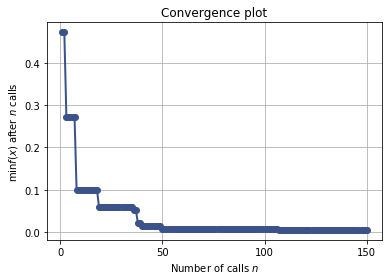

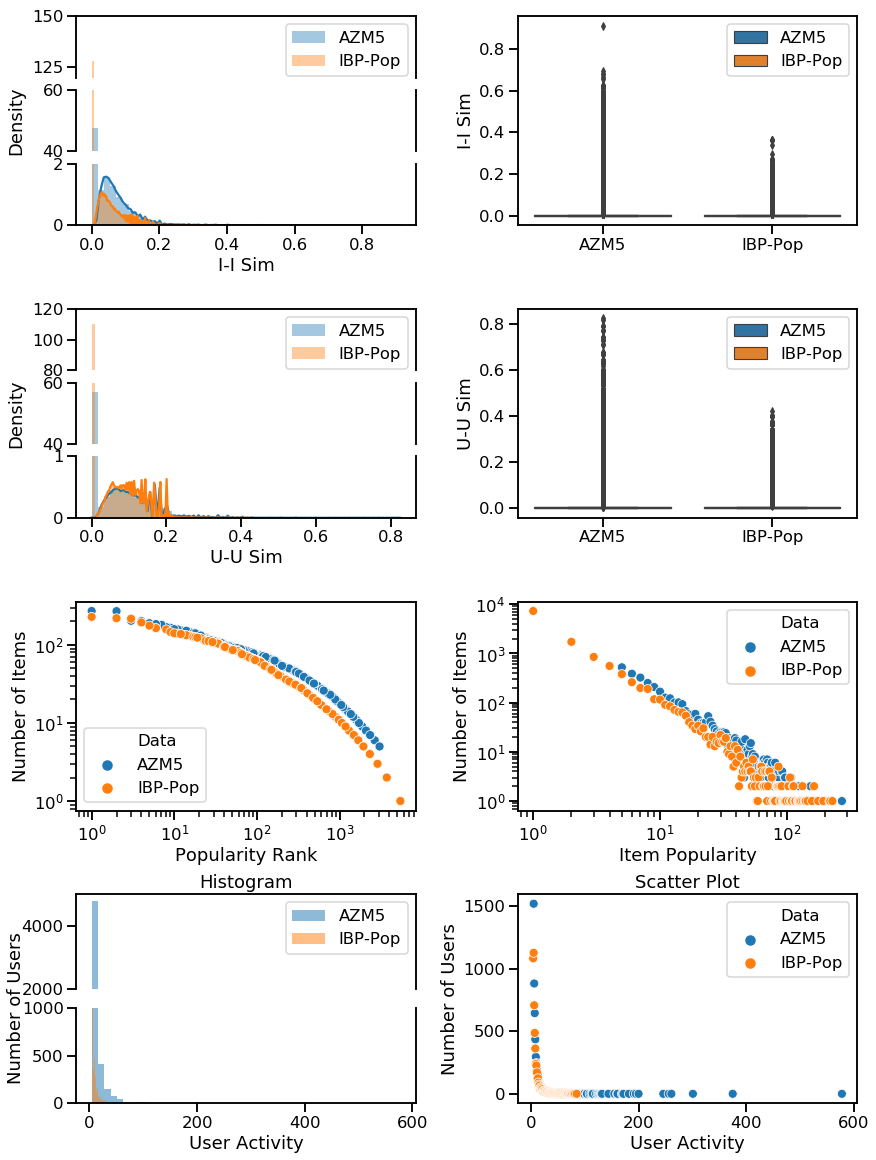

In [84]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-ucorr.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-az_music_5core-ucorr.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_pop', ibp_pop_pareto), args=[5541, *res_gp.x, 'ibp_pop_csr-az_music_5core-ucorr.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Pop', simulated_data),
               ylim_left=((120, 150), (40, 60), (0, 2)), ylim_left2=((80, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp pop on item pop

In [40]:
search_space('build/gp_minimize_ibp_pop_csr-az_music_5core-item-pop-1-2019-04-11-14-47-59.pkl')

[(20.000000000000004, 499.99999999999994), (0.01, 100.0), (0.0, 0.99), (4.5, 5.5), (0.1, 20.0), (520.2, 635.7999999999997)] 0.890089093533531


[10.0, 64.47278353556509, 0.0, 6.0, 0.1, 462.40000000000015] 0.7928914100350754
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  IBP-Pop    5541    2896   54963  0.003425
item popularity stats
              AZM5      IBP-Pop
count  3568.000000  2896.000000
mean     18.135090    18.978936
std      21.639818    36.028274
min       5.000000     1.000000
25%       6.000000     2.000000
50%      10.000000     5.000000
75%      20.000000    19.000000
max     272.000000   451.000000
user profile stats
              AZM5      IBP-Pop
count  5541.000000  5541.000000
mean     11.677676     9.919329
std      18.222800     3.157335
min       5.000000     1.000000
25%       5.000000     8.000000
50%       7.000000    10.000000
75%      11.000000    12.000000
max     578.000000    23.000000


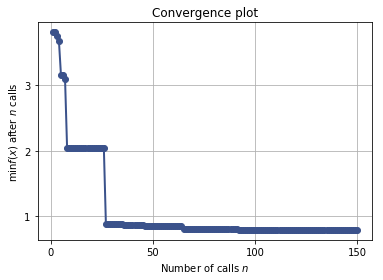

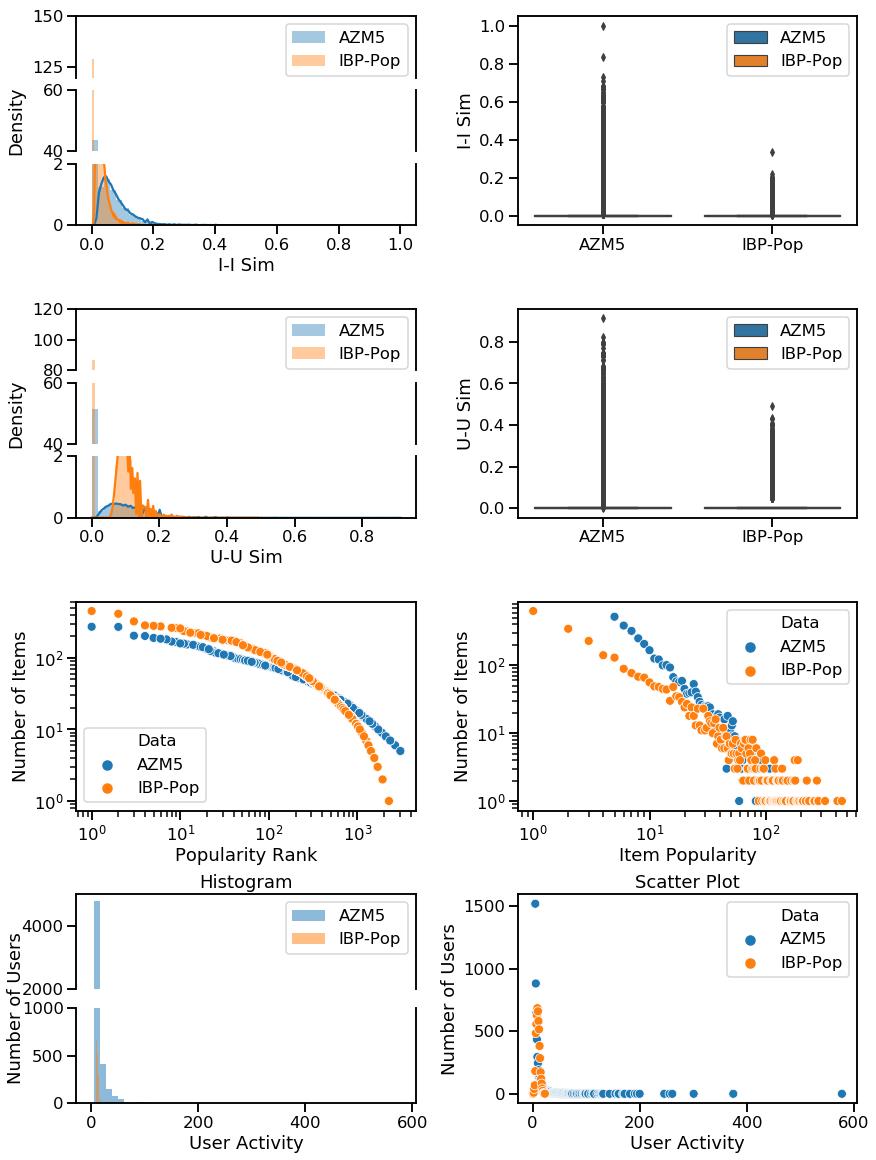

In [87]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-item-pop.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-az_music_5core-item-pop.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_pop', ibp_pop_pareto), args=[5541, *res_gp.x, 'ibp_pop_csr-az_music_5core-item-pop.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 5)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Pop', simulated_data),
               ylim_left=((120, 150), (40, 60), (0, 2)), ylim_left2=((80, 120), (40, 60), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp pop on user act

[317.94635459839037, 100.0, 0.99, 5.011987901653008, 1.6557669773725299, 462.40000000000015] 0.026417552917467436
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  IBP-Pop    5541   54606   64863  0.000214
item popularity stats
              AZM5       IBP-Pop
count  3568.000000  54606.000000
mean     18.135090      1.187837
std      21.639818      2.089826
min       5.000000      1.000000
25%       6.000000      1.000000
50%      10.000000      1.000000
75%      20.000000      1.000000
max     272.000000    130.000000
user profile stats
              AZM5      IBP-Pop
count  5541.000000  5541.000000
mean     11.677676    11.706010
std      18.222800    16.148589
min       5.000000     5.000000
25%       5.000000     6.000000
50%       7.000000     7.000000
75%      11.000000    11.000000
max     578.000000   297.000000


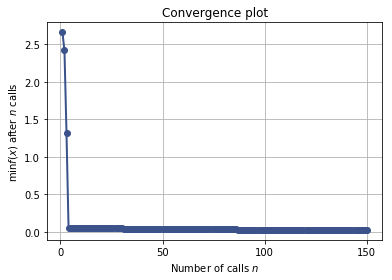

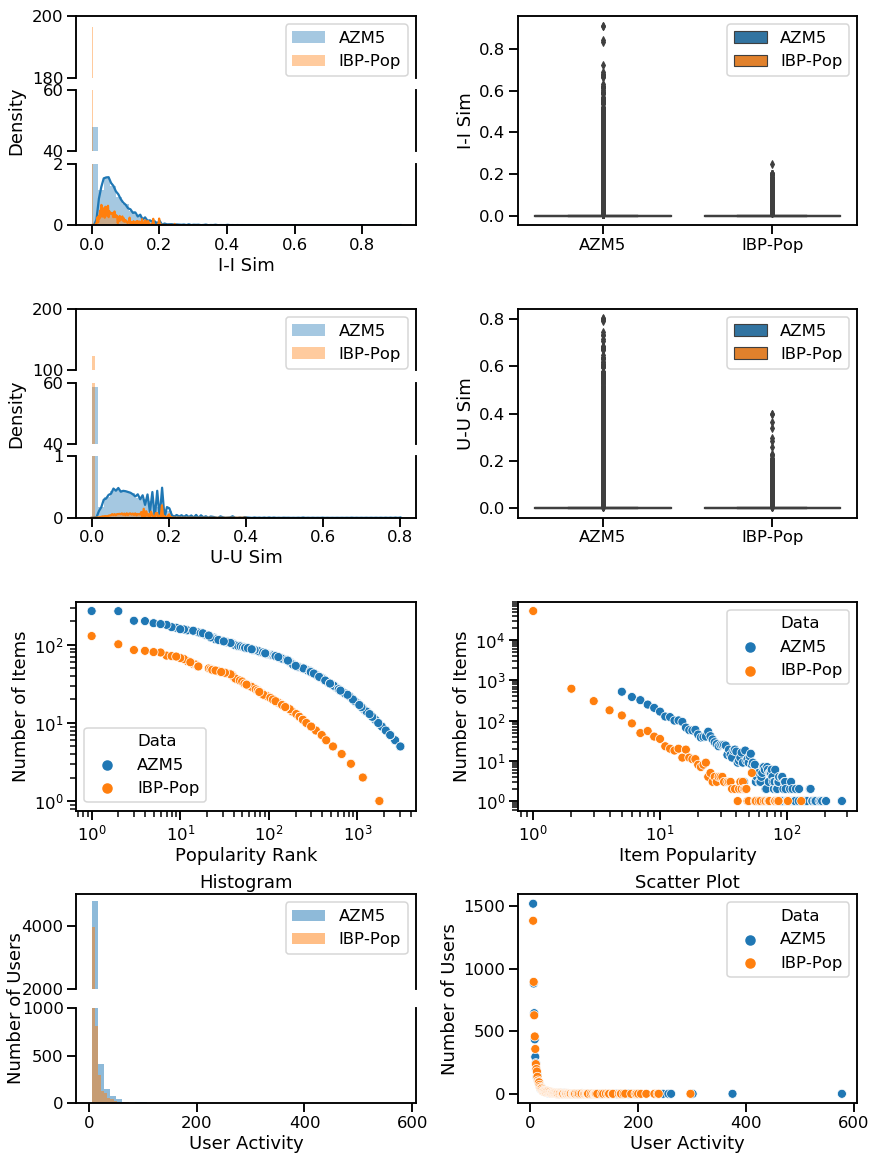

In [91]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-user-act.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop_csr-az_music_5core-user-act.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('azmi', az_music_5core), ('ibp_pop', ibp_pop_pareto), args=[5541, *res_gp.x, 'ibp_pop_csr-az_music_5core-user-act.pkl'],
               ylim_left=((40, 50), (0, 5)), ylim_left2=((70, 80), (40, 50), (0, 2)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=1)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Pop', simulated_data),
               ylim_left=((180, 200), (40, 60), (0, 2)), ylim_left2=((100, 200), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)), mrated=5)

### ibp pop on relative loss

In [11]:
res_gp = skopt.load('build/gp_minimize_ibp_pop_csr-az_music_5core-ucorr.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))
res_gp = skopt.load('build/skopt_ibp_pop-az_music_5core.pkl')
print(list(zip(np.min(res_gp.x_iters, axis=0), np.max(res_gp.x_iters, axis=0))))

[(10.0, 1000.0), (0.01, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)]
[(10.439449029064827, 1000.0), (0.010020309242744482, 100.0), (0.0, 0.99), (4.0, 6.0), (0.1, 20.0), (462.40000000000015, 693.5999999999997)]


[439.8484026775351, 35.59110472682988, 0.33742219521358646, 5.617862917673925, 1.7198720974952995, 609.966799755082] 10.313036663101945
simulated data is used
dataset stats
   dataset  nusers  nitems  npairs   density
0     AZM5    5541    3568   64706  0.003273
1  IBP-Pop    5541   16083   70096  0.000787
item popularity stats
              AZM5       IBP-Pop
count  3568.000000  16083.000000
mean     18.135090      4.358391
std      21.639818      8.636024
min       5.000000      1.000000
25%       6.000000      1.000000
50%      10.000000      2.000000
75%      20.000000      4.000000
max     272.000000    189.000000
user profile stats
              AZM5      IBP-Pop
count  5541.000000  5541.000000
mean     11.677676    12.650424
std      18.222800    19.989347
min       5.000000     5.000000
25%       5.000000     6.000000
50%       7.000000     8.000000
75%      11.000000    12.000000
max     578.000000   444.000000


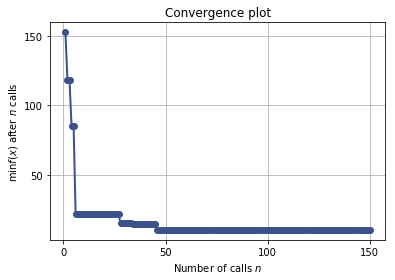

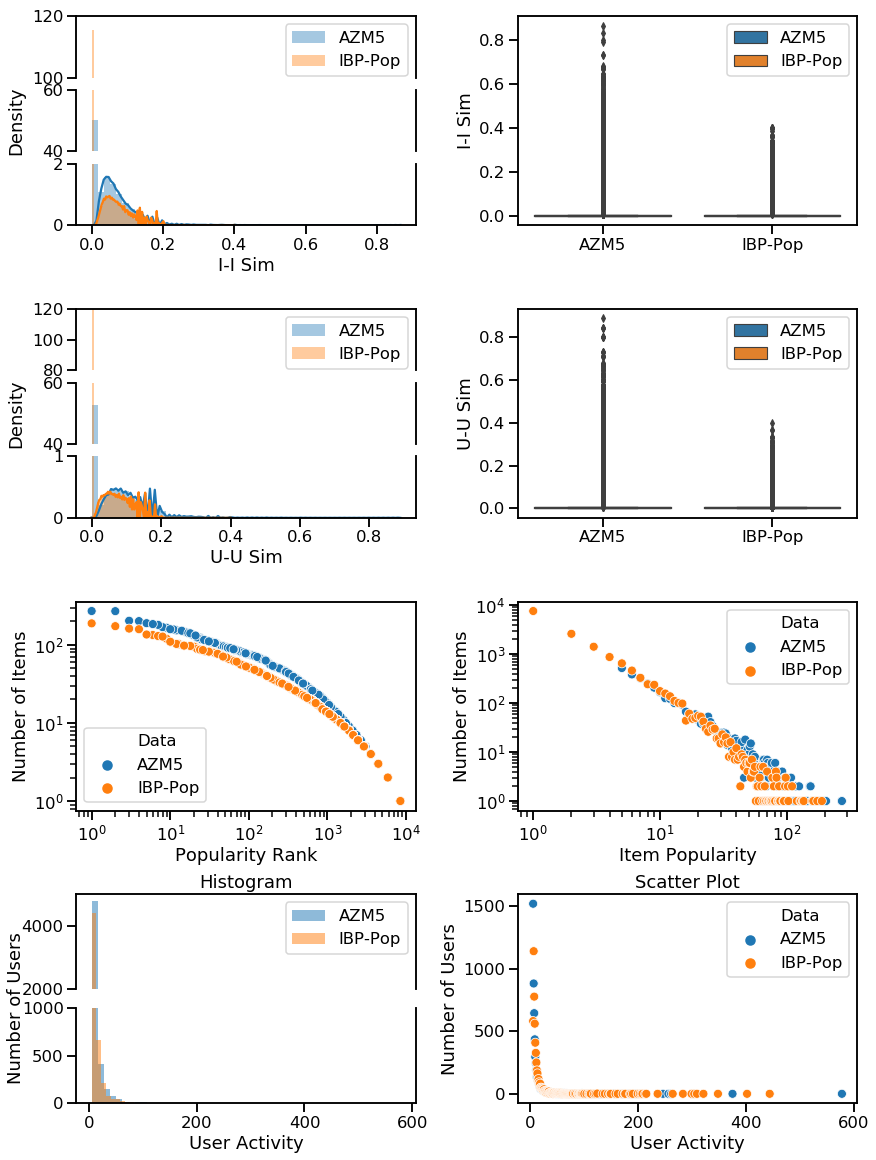

In [95]:
res_gp = skopt.load('build/skopt_ibp_pop-az_music_5core.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/ibp_pop-az_music_5core.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
    plot_stats(('AZM5', az_music_5core), ('IBP-Pop', ibp_pop_pareto), args=[5541, *res_gp.x, 'ibp_pop-az_music_5core.pkl'], mrated=5)
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('IBP-Pop', simulated_data), mrated=5,
               ylim_left=((100, 120), (40, 60), (0, 2)), ylim_left2=((80, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)))

### Unif Unif on relative loss

[2000.0, 4.941209314782768, 1.983535877337796, 693.5999999999997] 11.476317103638216
simulated data is used
dataset stats
     dataset  nusers  nitems  npairs   density
0       AZM5    5541    3568   64706  0.003273
1  UNIF-Unif    5541    3568   53072  0.002684
item popularity stats
              AZM5    UNIF-Unif
count  3568.000000  3568.000000
mean     18.135090    14.874439
std      21.639818     3.785596
min       5.000000     4.000000
25%       6.000000    12.000000
50%      10.000000    15.000000
75%      20.000000    17.000000
max     272.000000    29.000000
user profile stats
              AZM5    UNIF-Unif
count  5541.000000  5541.000000
mean     11.677676     9.578055
std      18.222800    12.525220
min       5.000000     4.000000
25%       5.000000     5.000000
50%       7.000000     7.000000
75%      11.000000    10.000000
max     578.000000   355.000000


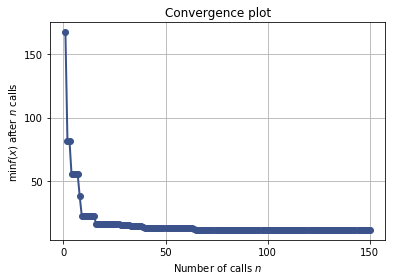

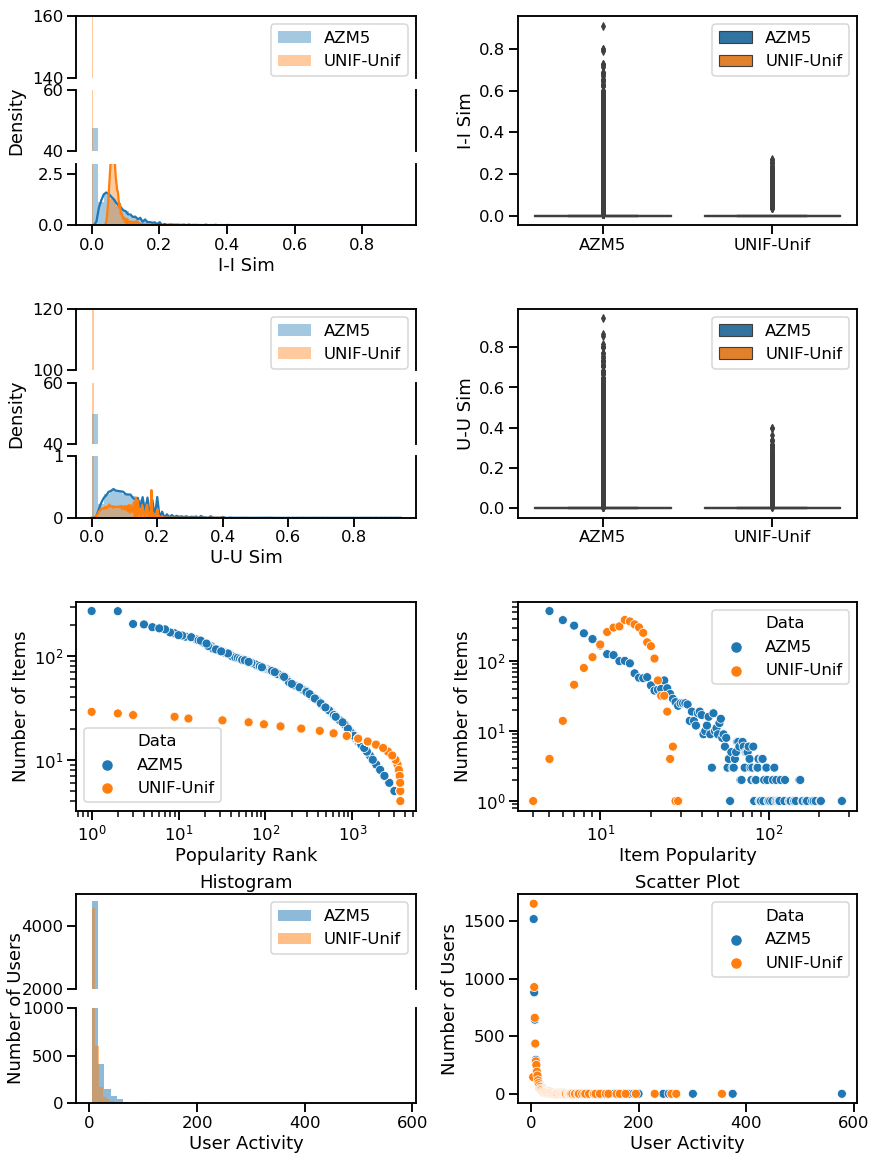

In [100]:
res_gp = skopt.load('build/skopt_unif_unif-az_music_5core.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_unif-az_music_5core.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('UNIF-Unif', simulated_data), mrated=5,
               ylim_left=((140, 160), (40, 60), (0, 3)), ylim_left2=((100, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)))

### Unif pop on relative loss

[966.0825372097964, 4.492077368126762, 1.9020772556331955, 693.5999999999997] 12.094139143957069
simulated data is used
dataset stats
    dataset  nusers  nitems  npairs   density
0      AZM5    5541    3568   64706  0.003273
1  UNIF-Pop    5541    3568   47960  0.002426
item popularity stats
              AZM5     UNIF-Pop
count  3568.000000  3568.000000
mean     18.135090    13.441704
std      21.639818     3.674745
min       5.000000     1.000000
25%       6.000000    11.000000
50%      10.000000    13.000000
75%      20.000000    16.000000
max     272.000000    26.000000
user profile stats
              AZM5     UNIF-Pop
count  5541.000000  5541.000000
mean     11.677676     8.655477
std      18.222800    11.275107
min       5.000000     4.000000
25%       5.000000     5.000000
50%       7.000000     6.000000
75%      11.000000     9.000000
max     578.000000   357.000000


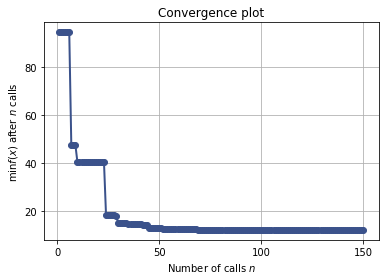

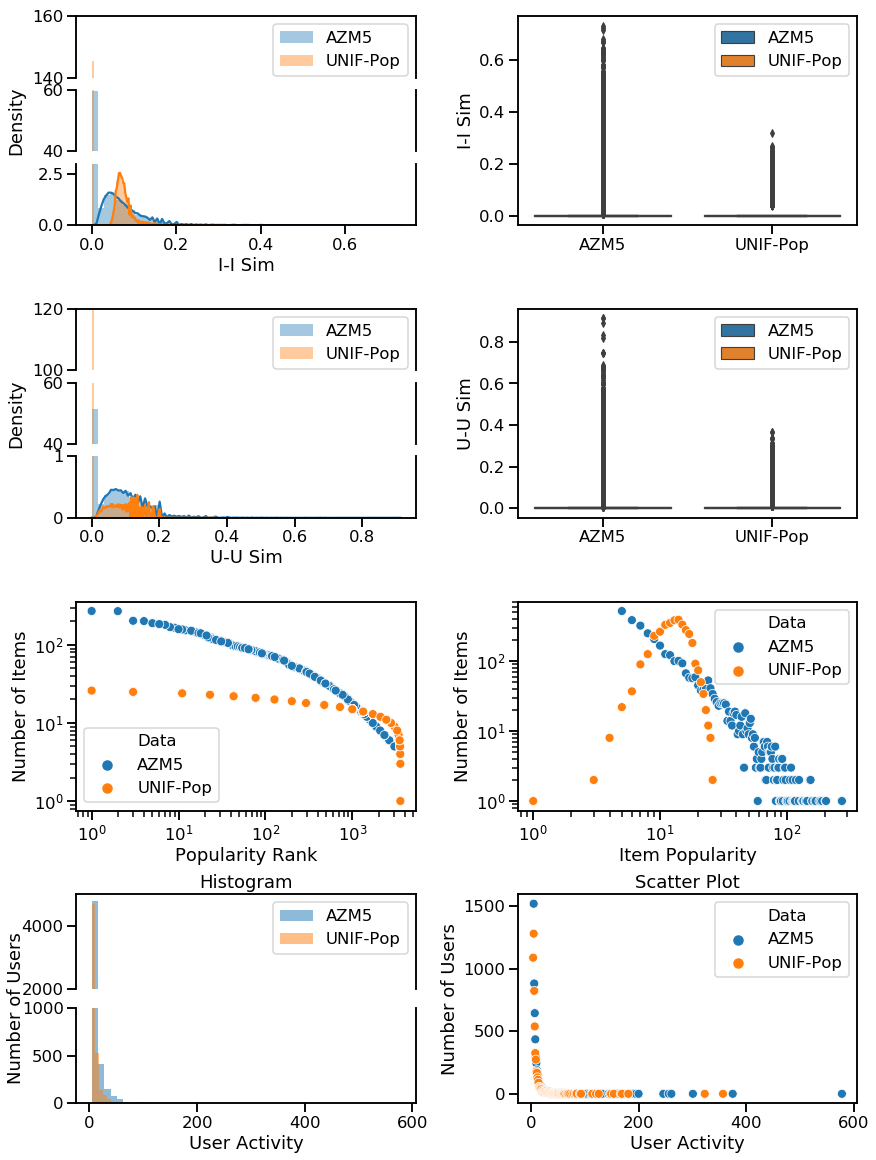

In [101]:
res_gp = skopt.load('build/skopt_unif_pop-az_music_5core.pkl')
plot_convergence(res_gp)

print(res_gp.x, res_gp.fun)

try:
    with open('data/simulated/unif_pop-az_music_5core.pkl', 'rb') as f:
        simulated_data = pickle.load(f)
except FileNotFoundError:
    print('file not found, simulating data on the fly')
else:
    print('simulated data is used')
    plot_stats(('AZM5', az_music_5core), ('UNIF-Pop', simulated_data), mrated=5,
               ylim_left=((140, 160), (40, 60), (0, 3)), ylim_left2=((100, 120), (40, 60), (0, 1)),
               ylim_left4=((2000, 5000), (0, 1000)))